# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
!pip install PyDrive
!pip install keras==2.2.4
!pip install tensorflow==1.13.1
!pip install git+https://github.com/darecophoenixx/wordroid.sblo.jp

     |████████████████████████████████| 317kB 4.6MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 92.5MB 53kB/s 
     |████████████████████████████████| 368kB 37.2MB/s 
     |████████████████████████████████| 3.2MB 45.1MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0
  Cloning https://github.com/darecophoenixx/wordroid.sblo.jp to /tmp/pip-req-build-sv7ngvsm
  Running command git clone -q https://github.com/darecophoenixx/wordroid.sblo.jp /tmp/pip-req-build-sv7ngvsm
  Created wheel for wordroid.sblo.

In [2]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras_ex.gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

#Set seeds
random.seed(1)
np.random.seed(1)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,self.imsize)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (-0.5)*euclidean(individual-self.img.reshape(1,self.imsize))/(self.imsize*255) 

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = euclidean(self.X_best.reshape(self.imsize)-self.img.reshape(self.imsize))
        individual = self.X_best.reshape(1,self.imsize)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"16oao6c9BTb33sbaFzCDJ1sGQn4Z0ILS7"}) 
downloaded.GetContentFile('rbfnn_v2.h5')   

num_lm0 = 100
num_lm = num_lm0 * 10
init_wgt = np.zeros(((1000, 784)))

inp = Input(shape=(28*28,), name='inp')
oup = GaussianKernel(num_lm, 28*28,
                     kernel_gamma='auto', weights=[init_wgt],
                     name='gkernel1')(inp)
oup = Dense(10, activation='softmax')(oup)
model = Model(inp, oup)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("rbfnn_v2.h5")

Instructions for updating:
Colocations handled automatically by placer.


# Prepare Data

In [0]:
import pickle
file_ = open('subset', 'rb')
dump = pickle.load(file_)
adversarial = pickle.load(file_)
dump = pickle.load(file_)
adversarial_y = pickle.load(file_)
file_.close()
del dump

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 20, #50 (5) #200 (1)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2) (it was 2000)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4) (it was 125)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

25  :  0.3718788755534659 25
50  :  0.4797271172956792 25
75  :  0.4539356112067489 25
100  :  0.4800184832042628 25
125  :  0.4850049608290755 25
150  :  0.4869712173211039 25
175  :  0.489445717495377 25
200  :  0.4908582593584101 25
225  :  0.48992767055282554 25
250  :  0.49105617850780386 25
275  :  0.490867423544944 25
300  :  0.4912472539526035 25
325  :  0.4917991100304764 25
350  :  0.4918173027626322 25
375  :  0.49193616018730946 25
400  :  0.4919052316470199 25
425  :  0.4919618706444003 25
450  :  0.4919618706444003 25
475  :  0.4921205058942631 25
500  :  0.49230250250469937 25
525  :  0.4923035878185413 25
550  :  0.4923035878185413 25
575  :  0.49234435773123786 25
600  :  0.4923453731781139 25
625  :  0.4923817480434116 25
650  :  0.4923853144126922 25
675  :  0.49241981670382234 25
700  :  0.49245484241838655 25
725  :  0.4924633133319208 25
750  :  0.4924727295206735 25
775  :  0.4924727295206735 25
800  :  0.4924926293022795 25
825  :  0.49249844976694374 25
850  : 

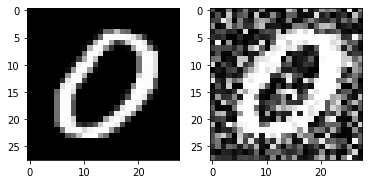

25  :  0.3776315984279073 25
50  :  0.48078779954756207 25
75  :  0.4590827557693818 25
100  :  0.4680537241811788 25
125  :  0.4844460651762954 25
150  :  0.4872240467746978 25
175  :  0.4868051513757021 25
200  :  0.48807700820809746 25
225  :  0.4881495966770188 25
250  :  0.4882564685506625 25
275  :  0.4892240828131813 25
300  :  0.4897567352791728 25
325  :  0.48983919661386094 25
350  :  0.4901960291869497 25
375  :  0.49030406673200977 25
400  :  0.4905592048574111 25
425  :  0.4907100101751003 25
450  :  0.49085190083471425 25
475  :  0.4908720757026548 25
500  :  0.4908936553487052 25
525  :  0.4908936553487052 25
550  :  0.49090534569948974 25
575  :  0.4911331896909234 25
600  :  0.4911498630368196 25
625  :  0.4911991786254191 25
650  :  0.4912104982583084 25
675  :  0.4913702207341995 25
700  :  0.4915320516244203 25
725  :  0.4915383897652347 25
750  :  0.491542454383973 25
775  :  0.49159367660456116 25
800  :  0.49161160468962023 25
825  :  0.49169742215273693 25
850  

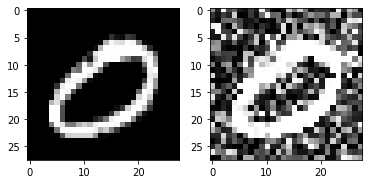

25  :  0.3943645711075099 25
50  :  0.4818819048538724 25
75  :  0.46485510579845474 25
100  :  0.4792464017017906 25
125  :  0.48490720909346036 25
150  :  0.4853810942241172 25
175  :  0.48780506039395466 25
200  :  0.48932068555625036 25
225  :  0.4894677131059036 25
250  :  0.48971046996385514 25
275  :  0.4898973625364196 25
300  :  0.4899261335564497 25
325  :  0.49012652150442043 25
350  :  0.49041764981471403 25
375  :  0.4904392649217355 25
400  :  0.490728158673158 25
425  :  0.49083020535970845 25
450  :  0.4909755270394151 25
475  :  0.49096597336405023 25
500  :  0.49096597336405023 25
525  :  0.49096597336405023 25
550  :  0.4913017798659238 25
575  :  0.49135838429579703 25
600  :  0.49137146584595653 25
625  :  0.4914835019894638 25
650  :  0.4914871343731794 25
675  :  0.4914871343731794 25
700  :  0.49152771636389053 25
725  :  0.49155287190029756 25
750  :  0.4916133484225101 25
775  :  0.4916553626780655 25
800  :  0.4916868732320382 25
825  :  0.49169593140094736 2

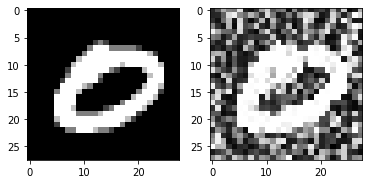

25  :  -0.081083505160395 25
50  :  0.3093416175875057 25
75  :  0.26242435862429153 25
100  :  0.42933285574812907 25
125  :  0.43320134485653156 25
150  :  0.46197973864299013 25
175  :  0.4811076874058256 25
200  :  0.4859700495386337 25
225  :  0.48706458208816306 25
250  :  0.4878263111180674 25
275  :  0.4877021808921801 25
300  :  0.48946606268219217 25
325  :  0.48920752255750066 25
350  :  0.4892264427220727 25
375  :  0.4896727873786922 25
400  :  0.489888717362964 25
425  :  0.4899654004133538 25
450  :  0.4900144605768486 25
475  :  0.490259980722804 25
500  :  0.49034230154969993 25
525  :  0.49038366539141465 25
550  :  0.49052278103926533 25
575  :  0.49061683872088313 25
600  :  0.490717672500774 25
625  :  0.4909053053212406 25
650  :  0.49093677899330257 25
675  :  0.49110456903068983 25
700  :  0.4911111393310788 25
725  :  0.491113917603905 25
750  :  0.4911784041247474 25
775  :  0.49121963970314575 25
800  :  0.4912223341075575 25
825  :  0.4912887957467599 25
850

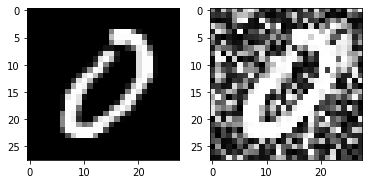

25  :  0.44823835682760627 25
50  :  0.48652079458452246 25
75  :  0.4773181132963049 25
100  :  0.48155382294394505 25
125  :  0.4898801331124639 25
150  :  0.48946537447708127 25
175  :  0.4905403402270071 25
200  :  0.4910653777614504 25
225  :  0.4911005502441578 25
250  :  0.4912793347049566 25
275  :  0.49160877635660144 25
300  :  0.4919825011360294 25
325  :  0.49197385059027104 25
350  :  0.4920336661278303 25
375  :  0.4922245301037539 25
400  :  0.4922540257891223 25
425  :  0.49251335483593806 25
450  :  0.4925317510251632 25
475  :  0.4926079089624073 25
500  :  0.4926954796225395 25
525  :  0.4927242548293203 25
550  :  0.4927828951134266 25
575  :  0.49289873944683793 25
600  :  0.49289873944683793 25
625  :  0.49290005134140835 25
650  :  0.4929079098603724 25
675  :  0.4929377378424374 25
700  :  0.49294756860204964 25
725  :  0.4929617951374933 25
750  :  0.4929969910876258 25
775  :  0.4929969910876258 25
800  :  0.4930036483538459 25
825  :  0.49301658598192194 25
T

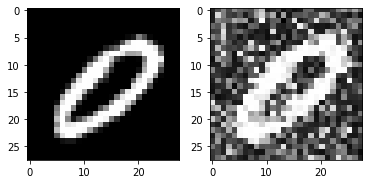

25  :  0.4127006015425266 25
50  :  0.48273203389861064 25
75  :  0.4850838046076142 25
100  :  0.4874066261594642 25
125  :  0.4866515312007789 25
150  :  0.4894537007093284 25
175  :  0.48974965168695084 25
200  :  0.4900233926904135 25
225  :  0.4917520975116399 25
250  :  0.4918277521750927 25
275  :  0.49196985726479986 25
300  :  0.4917890602309191 25
325  :  0.4928815890470643 25
350  :  0.49296913600016173 25
375  :  0.4930885849044524 25
400  :  0.4931545355922069 25
425  :  0.49363275284312186 25
450  :  0.4936285511115048 25
475  :  0.49375275851588135 25
500  :  0.4937774880674383 25
525  :  0.4937774880674383 25
550  :  0.4937945379345886 25
575  :  0.4937945379345886 25
600  :  0.49392269603885847 25
625  :  0.49390198332754587 25
650  :  0.49390198332754587 25
675  :  0.49390198332754587 25
700  :  0.49394525847328624 25
725  :  0.4940440319278311 25
750  :  0.49403164471600736 25
775  :  0.49403164471600736 25
800  :  0.4941049427032915 25
825  :  0.4941103089344867 25


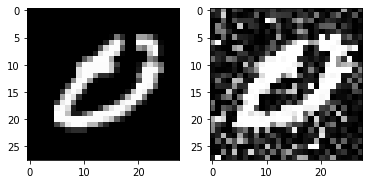

25  :  -0.3888178106383579 25
50  :  0.3484199833777493 25
75  :  0.2805303885837657 25
100  :  0.2382465340119235 25
125  :  0.34053885360813774 25
150  :  0.41679293795734457 25
175  :  0.47282321242068254 25
200  :  0.486769096698928 25
225  :  0.48629511489845134 25
250  :  0.4866213925839346 25
275  :  0.48592243690568565 25
300  :  0.48674943215259225 25
325  :  0.4869839694290913 25
350  :  0.48735338876836237 25
375  :  0.4871629752153056 25
400  :  0.4877067003663069 25
425  :  0.4879620419098677 25
450  :  0.4879326207287417 25
475  :  0.4883419838851337 25
500  :  0.4884248989905443 25
525  :  0.48888468668622526 25
550  :  0.48888249758707775 25
575  :  0.48890161773467344 25
600  :  0.4889948979571104 25
625  :  0.4890817671896268 25
650  :  0.48914107222063047 25
675  :  0.48926168945767573 25
700  :  0.4894427769837804 25
725  :  0.48957672571823774 25
750  :  0.48957672571823774 25
775  :  0.489640462455532 25
800  :  0.48966444238036183 25
825  :  0.48974019684870107 2

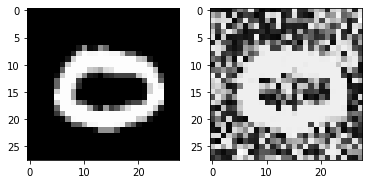

25  :  -0.3179209209303204 25
50  :  0.2572696550999157 25
75  :  0.19703163908153945 25
100  :  0.329446285801595 25
125  :  0.35427007725873266 25
150  :  0.4548196201360252 25
175  :  0.47694774245858934 25
200  :  0.4865076703914553 25
225  :  0.4844459926482531 25
250  :  0.48492286634953946 25
275  :  0.48609683091762773 25
300  :  0.48689518241031515 25
325  :  0.4876571682324365 25
350  :  0.4880112368733376 25
375  :  0.4888492228627183 25
400  :  0.4884846999726002 25
425  :  0.4892968380500536 25
450  :  0.4895753920654168 25
475  :  0.4898518900435237 25
500  :  0.4895457670740446 25
525  :  0.4902937855596694 25
550  :  0.4902937855596694 25
575  :  0.4904101608297847 25
600  :  0.4905947379314045 25
625  :  0.4906338636200711 25
650  :  0.4908592711887967 25
675  :  0.4908437021504827 25
700  :  0.49097808778148533 25
725  :  0.49101542769960016 25
750  :  0.49101542769960016 25
775  :  0.4910520900862104 25
800  :  0.4912110022660867 25
825  :  0.491205369834049 25
850  

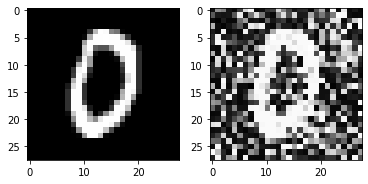

25  :  0.015567915398160194 25
50  :  0.44375997359088026 25
75  :  0.27089542350473883 25
100  :  0.24101539290628346 25
125  :  0.406412595886151 25
150  :  0.43835012296187736 25
175  :  0.46458553932265617 25
200  :  0.4745702739959706 25
225  :  0.48173359182447517 25
250  :  0.48209280205333416 25
275  :  0.48367098853131063 25
300  :  0.483763651654115 25
325  :  0.4843965492631651 25
350  :  0.48452105818762486 25
375  :  0.4842637337489301 25
400  :  0.485571337441998 25
425  :  0.48698006194428484 25
450  :  0.4868799614153995 25
475  :  0.48699345246698633 25
500  :  0.48699345246698633 25
525  :  0.48747614528628047 25
550  :  0.4881069081329524 25
575  :  0.48895617104140887 25
600  :  0.48895617104140887 25
625  :  0.48895617104140887 25
650  :  0.48895617104140887 25
675  :  0.48895617104140887 25
700  :  0.48895617104140887 25
725  :  0.48914507304913646 25
750  :  0.4892727597195524 25
775  :  0.4895340187330304 25
800  :  0.4895416526388971 25
825  :  0.48956270266072

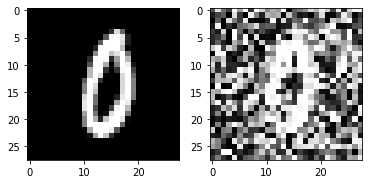

25  :  0.03476727943957512 25
50  :  0.4715395276242256 25
75  :  0.3629882078279275 25
100  :  0.4501086908298631 25
125  :  0.46019854559495244 25
150  :  0.4839524846453581 25
175  :  0.4856961621575796 25
200  :  0.4864396871085838 25
225  :  0.48661851877723206 25
250  :  0.4871709919942555 25
275  :  0.48792822478507325 25
300  :  0.48821472246481973 25
325  :  0.4885231245625459 25
350  :  0.4887587208021462 25
375  :  0.4886249643288412 25
400  :  0.48883301695908754 25
425  :  0.4894565048938853 25
450  :  0.48912810344333973 25
475  :  0.4892622473848917 25
500  :  0.4895890863511975 25
525  :  0.4896835734054001 25
550  :  0.48976059448175635 25
575  :  0.48982526985288055 25
600  :  0.4898733064261848 25
625  :  0.4899868173881351 25
650  :  0.4900617556110783 25
675  :  0.490206149692984 25
700  :  0.4903402819033126 25
725  :  0.49038051320906983 25
750  :  0.4903876406389138 25
775  :  0.4903862175539481 25
800  :  0.490388464263078 25
825  :  0.4904861527614571 25
850  

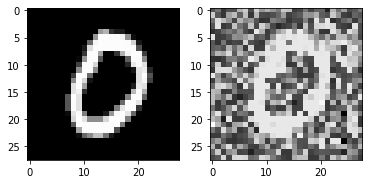

25  :  0.49197521199901023 25
50  :  0.49224663407282293 25
75  :  0.49205690749634556 25
100  :  0.49279351161349677 25
125  :  0.491607346937179 25
150  :  0.4927768676297741 25
175  :  0.4927768676297741 25
200  :  0.4931539519454022 25
225  :  0.49285742651049497 25
250  :  0.4933085691905063 25
275  :  0.49354652586781295 25
300  :  0.4935177339508512 25
325  :  0.49364913925113557 25
350  :  0.4937748137262447 25
375  :  0.4939000149431971 25
400  :  0.49390548729678607 25
425  :  0.4940298540397354 25
450  :  0.4941262231658204 25
475  :  0.49413174269812304 25
500  :  0.49414919084506875 25
525  :  0.49417393413860927 25
550  :  0.4942706080613491 25
575  :  0.4943617692973282 25
600  :  0.4943645359332729 25
625  :  0.49436942757669267 25
650  :  0.49440040673633195 25
675  :  0.49441500849744524 25
700  :  0.4944394978346303 25
725  :  0.49444509658526586 25
750  :  0.49447571422862646 25
775  :  0.49447549253388307 25
800  :  0.4944777489058866 25
Time:  77.53662419319153  s

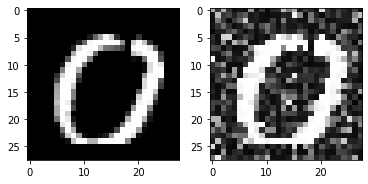

25  :  -0.15641045331082243 25
50  :  0.4181127706161122 25
75  :  0.3499421937401944 25
100  :  0.40915877498424 25
125  :  0.4580004028932119 25
150  :  0.4657358932095221 25
175  :  0.48195437812263103 25
200  :  0.48432812642282036 25
225  :  0.48476125906554224 25
250  :  0.486130862202796 25
275  :  0.48722511236364524 25
300  :  0.48770423341684177 25
325  :  0.4880949165077665 25
350  :  0.4883399671736047 25
375  :  0.488960093146247 25
400  :  0.48874935854416085 25
425  :  0.4899611668563545 25
450  :  0.489813620818543 25
475  :  0.4900917876085806 25
500  :  0.4900348806405483 25
525  :  0.49064689935306804 25
550  :  0.49073080813015224 25
575  :  0.4908045373180811 25
600  :  0.49090271504231364 25
625  :  0.49101445311769243 25
650  :  0.4911105444132223 25
675  :  0.491116922627972 25
700  :  0.4911438968372215 25
725  :  0.4912871505449712 25
750  :  0.49136395011544254 25
775  :  0.49136496652834727 25
800  :  0.49143666609279657 25
825  :  0.49146935895299865 25
850

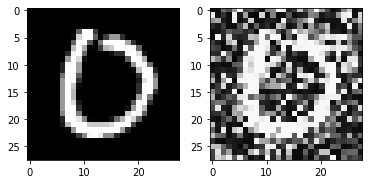

25  :  0.4682611684352398 25
50  :  0.4801765835243368 25
75  :  0.477648153566137 25
100  :  0.48086499169854297 25
125  :  0.4857127510612811 25
150  :  0.48889847923967705 25
175  :  0.49066259962149267 25
200  :  0.49066259962149267 25
225  :  0.492447178122049 25
250  :  0.49318089161392903 25
275  :  0.49374110215131956 25
300  :  0.49392403529235024 25
325  :  0.49416994099740597 25
350  :  0.4943676499875425 25
375  :  0.4943893231530569 25
400  :  0.49469556411691407 25
425  :  0.49472725246172894 25
450  :  0.49510833046852204 25
475  :  0.49504224429884636 25
500  :  0.49526052316148916 25
525  :  0.4953625457555452 25
550  :  0.49543406507688637 25
575  :  0.49552760778538996 25
600  :  0.49564518296155197 25
625  :  0.4956723539566137 25
650  :  0.4956834286705592 25
675  :  0.4957124139257282 25
700  :  0.4957416674072499 25
725  :  0.49576742794645906 25
750  :  0.495815951557766 25
775  :  0.495815951557766 25
800  :  0.4958209276728646 25
825  :  0.495844003507107 25
T

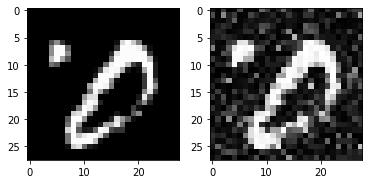

25  :  -0.3732048673613444 25
50  :  -0.10620875309852752 25
75  :  0.10431385808649797 25
100  :  0.27566820563586286 25
125  :  0.4092378793013361 25
150  :  0.4450070851526415 25
175  :  0.45904079884302773 25
200  :  0.45604331225368067 25
225  :  0.4418615124474282 25
250  :  0.4578295769383029 25
275  :  0.4357551261973251 25
300  :  0.45118701821905355 25
325  :  0.43578403178986186 25
350  :  0.4538385488504662 25
375  :  0.45416358939279544 25
400  :  0.46932679475249106 25
425  :  0.47172096226435883 25
450  :  0.47172096226435883 25
475  :  0.47635972242350494 25
500  :  0.4799450717213998 25
525  :  0.4799450717213998 25
550  :  0.4799450717213998 25
575  :  0.4799450717213998 25
600  :  0.4822407938232865 25
625  :  0.4831261941451791 25
650  :  0.4838564573598968 25
675  :  0.4843420752178434 25
700  :  0.4865585692393583 25
725  :  0.487052142504219 25
750  :  0.4882494207507573 25
775  :  0.48926745812693256 25
800  :  0.49016956955727653 25
825  :  0.4912656827038457 2

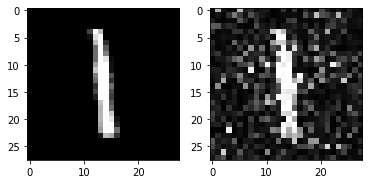

25  :  -0.44542195415250396 25
50  :  -0.32333002871835204 25
75  :  -0.23853184661886548 25
100  :  0.22805163113662819 25
125  :  0.36318024370261415 25
150  :  0.4283647843588799 25
175  :  0.4702325628188355 25
200  :  0.47452155711915606 25
225  :  0.47680887793547216 25
250  :  0.47875663112822076 25
275  :  0.4820458167847022 25
300  :  0.4812359114977031 25
325  :  0.4812359114977031 25
350  :  0.48620535556522415 25
375  :  0.4865695964165384 25
400  :  0.4865695964165384 25
425  :  0.4873532409156211 25
450  :  0.49013401853542915 25
475  :  0.49137096706717287 25
500  :  0.4923180307362462 25
525  :  0.4924248868046675 25
550  :  0.4924248868046675 25
575  :  0.49252829278104027 25
600  :  0.49252829278104027 25
625  :  0.49252829278104027 25
650  :  0.4925378026751928 25
675  :  0.49298649131187244 25
700  :  0.49300619202673723 25
725  :  0.4930422157326397 25
750  :  0.4931961166980024 25
775  :  0.4933619016106194 25
800  :  0.4934182914942513 25
825  :  0.49364973323343

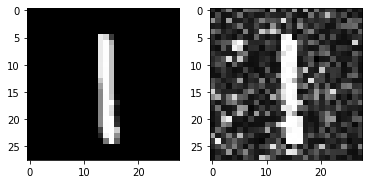

25  :  -0.3786932188442002 25
50  :  0.04631695477238036 25
75  :  0.1965794352245585 25
100  :  0.4327031996365126 25
125  :  0.4532942373592116 25
150  :  0.4505746427021609 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


175  :  0.462024380273669 25
200  :  0.4780404015511311 25
225  :  0.47749130377536964 25
250  :  0.48009768654960283 25
275  :  0.4801139456578012 25
300  :  0.48086284627133946 25
325  :  0.48240971203958016 25
350  :  0.4826377798791161 25
375  :  0.4874390760265452 25
400  :  0.4876793858470277 25
425  :  0.48978564634492827 25
450  :  0.4899338875261775 25
475  :  0.49118691338500403 25
500  :  0.49118691338500403 25
525  :  0.49118691338500403 25
550  :  0.49118691338500403 25
575  :  0.49139947771603226 25
600  :  0.4919259571227389 25
625  :  0.4924205731097026 25
650  :  0.493143609503414 25
675  :  0.4935188823408306 25
700  :  0.49368244546692164 25
725  :  0.4936922185235026 25
750  :  0.49379572573979663 25
775  :  0.4939453066493112 25
800  :  0.4939719073145182 25
825  :  0.4940149351295057 25
850  :  0.49410443771931845 25
875  :  0.4941234701446782 25
900  :  0.4941234701446782 25
925  :  0.49417988607478347 25
950  :  0.49426058110906956 25
975  :  0.4942513365387702 

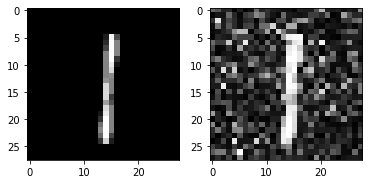

25  :  -0.49530550196813733 25
50  :  -0.43175083993113794 25
75  :  -0.3944473640728725 25
100  :  0.049670533598741906 25
125  :  0.26727559845867777 25
150  :  0.46036161106956736 25
175  :  0.463918670109458 25
200  :  0.47138337943229397 25
225  :  0.4786175912082237 25
250  :  0.48316140622682807 25
275  :  0.4813323760438771 25
300  :  0.48158731344532424 25
325  :  0.48158731344532424 25
350  :  0.48173938713592024 25
375  :  0.4844975633901183 25
400  :  0.4873703041570729 25
425  :  0.48788683574484765 25
450  :  0.4888899338673339 25
475  :  0.48903438442727626 25
500  :  0.48924918068647455 25
525  :  0.48992347950251225 25
550  :  0.4900318504801498 25
575  :  0.4910164461648696 25
600  :  0.49100734649321653 25
625  :  0.49189716586328525 25
650  :  0.4919374924030367 25
675  :  0.4920489425029772 25
700  :  0.49209736141948024 25
725  :  0.4926083113667038 25
750  :  0.49300126693745755 25
775  :  0.49300126693745755 25
800  :  0.49323137394786243 25
825  :  0.4932174200

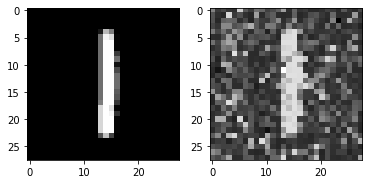

25  :  -0.3416734890877026 25
50  :  -0.22446339607333052 25
75  :  0.03720796713633321 25
100  :  0.3090781849544147 25
125  :  0.42403087831775377 25
150  :  0.42403087831775377 25
175  :  0.42808571987449623 25
200  :  0.4582263053370793 25
225  :  0.459731179849946 25
250  :  0.4635358747966013 25
275  :  0.46870610585038514 25
300  :  0.47132471905845913 25
325  :  0.4769620604565596 25
350  :  0.47786892517944185 25
375  :  0.4778883052526196 25
400  :  0.47861729785912666 25
425  :  0.480557779241173 25
450  :  0.48341197425952204 25
475  :  0.4869403315030378 25
500  :  0.4869366912441494 25
525  :  0.4888277418835755 25
550  :  0.48881175641365165 25
575  :  0.49024073107258564 25
600  :  0.4903163206403157 25
625  :  0.4920635571896281 25
650  :  0.49185747594471485 25
675  :  0.4923880914403343 25
700  :  0.49276899922422995 25
725  :  0.4928435461691562 25
750  :  0.4931091718822255 25
775  :  0.49329802318071625 25
800  :  0.49329474383299726 25
825  :  0.4936858970211696 

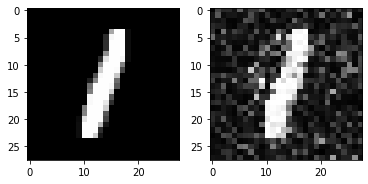

25  :  -0.010659038649335074 25
50  :  0.42258608063484193 25
75  :  0.26022429591454843 25
100  :  0.3866764717198918 25
125  :  0.4408357025191298 25
150  :  0.41007848263856234 25
175  :  0.43355820123197747 25
200  :  0.4355011344853285 25
225  :  0.44222001308229436 25
250  :  0.4519974325746349 25
275  :  0.45543984848459457 25
300  :  0.45543984848459457 25
325  :  0.45635960390922 25
350  :  0.46503235234348816 25
375  :  0.46940406424416514 25
400  :  0.46947097645439856 25
425  :  0.47504157775758216 25
450  :  0.47504157775758216 25
475  :  0.47504157775758216 25
500  :  0.47504157775758216 25
525  :  0.47545698970107686 25
550  :  0.4763081778941878 25
575  :  0.47763127519825904 25
600  :  0.47883394049977623 25
625  :  0.48060212518735734 25
650  :  0.4815809369889039 25
675  :  0.48292743040442926 25
700  :  0.4841168155152258 25
725  :  0.4849562214091609 25
750  :  0.48548339672960095 25
775  :  0.48637793301332477 25
800  :  0.4872100967803095 25
825  :  0.48772814511

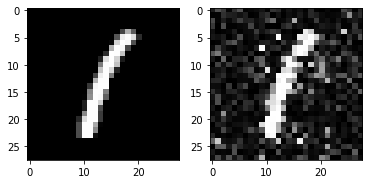

25  :  0.31881837309459005 25
50  :  0.31881837309459005 25
75  :  0.3868397642919764 25
100  :  0.4037728343378048 25
125  :  0.43025718611357616 25
150  :  0.42124975443897167 25
175  :  0.43142106742173675 25
200  :  0.4454100376668462 25
225  :  0.45143496678201656 25
250  :  0.45957089974920223 25
275  :  0.46704461246645307 25
300  :  0.4820873363591495 25
325  :  0.4820136109081149 25
350  :  0.4816530272924617 25
375  :  0.4839795955254836 25
400  :  0.48568731927056275 25
425  :  0.4825911024108453 25
450  :  0.4867705897639025 25
475  :  0.4853799198814864 25
500  :  0.4906131436875794 25
525  :  0.49000630737272877 25
550  :  0.49000630737272877 25
575  :  0.49146593989390014 25
600  :  0.4920380512763645 25
625  :  0.4920380512763645 25
650  :  0.492791694128468 25
675  :  0.4930631143389341 25
700  :  0.4930631143389341 25
725  :  0.4930631143389341 25
750  :  0.4938004573936809 25
775  :  0.4938997765456044 25
800  :  0.4942004210420368 25
825  :  0.4947516590980716 25
85

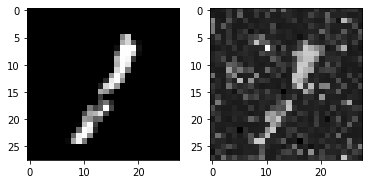

25  :  0.4038140259761275 25
50  :  0.48664025655728455 25
75  :  0.4173689530584072 25
100  :  0.4849227522618947 25
125  :  0.4797845263155328 25
150  :  0.4832569414103869 25
175  :  0.48734100177045614 25
200  :  0.4869523932833164 25
225  :  0.486237965471422 25
250  :  0.4876286912018775 25
275  :  0.48894748588762116 25
300  :  0.4894428726152479 25
325  :  0.49013268759667084 25
350  :  0.49013323019839516 25
375  :  0.49026459400255284 25
400  :  0.4907207011739483 25
425  :  0.49076051478190236 25
450  :  0.4910671572115464 25
475  :  0.49167339712982355 25
500  :  0.49162818157350907 25
525  :  0.4916749482971 25
550  :  0.49198687526441376 25
575  :  0.492156115903895 25
600  :  0.49199126291139667 25
625  :  0.49223315245581367 25
650  :  0.49223122272693015 25
675  :  0.49242374402058187 25
700  :  0.4925828012972741 25
725  :  0.4925648833897756 25
750  :  0.4925648833897756 25
775  :  0.4925966070842684 25
800  :  0.4926267848808815 25
825  :  0.49263377028506805 25
850

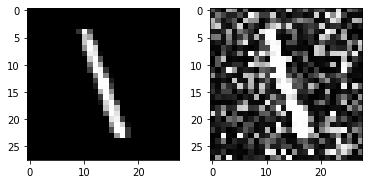

25  :  -0.3554288839083554 25
50  :  0.04517985149487834 25
75  :  0.10277073666253797 25
100  :  0.37960653782345394 25
125  :  0.44281374429039616 25
150  :  0.47136483101509696 25
175  :  0.47068367889510815 25
200  :  0.48111288324096074 25
225  :  0.48264364375280544 25
250  :  0.48583472804502087 25
275  :  0.48440678127642567 25
300  :  0.48634350583052843 25
325  :  0.4853495009111892 25
350  :  0.48785722694400385 25
375  :  0.4876613526623835 25
400  :  0.4878913449863295 25
425  :  0.48842426140855455 25
450  :  0.4888313206652364 25
475  :  0.4889577900796122 25
500  :  0.4893873539729864 25
525  :  0.48949885255722386 25
550  :  0.489679078618349 25
575  :  0.49014320685167484 25
600  :  0.49034027798875524 25
625  :  0.49051831712848115 25
650  :  0.4904580815705583 25
675  :  0.4905092220905628 25
700  :  0.4906137320015072 25
725  :  0.4905303384998112 25
750  :  0.49099075310938384 25
775  :  0.49084450676828567 25
800  :  0.491007024413743 25
825  :  0.490993436531916

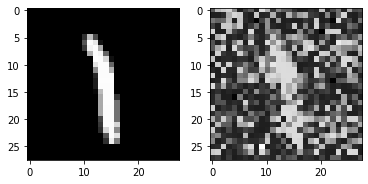

25  :  -0.48883394184027024 25
50  :  -0.3340637736779938 25
75  :  -0.4353759537762252 25
100  :  -0.2763600488352132 25
125  :  0.14666003421007678 25
150  :  0.3359074389450034 25
175  :  0.3580439974084873 25
200  :  0.44874205801024175 25
225  :  0.486981146538187 25
250  :  0.48747177740637065 25
275  :  0.486861739122819 25
300  :  0.48712838182864404 25
325  :  0.4877276987578036 25
350  :  0.48830486813246105 25
375  :  0.48836278349212764 25
400  :  0.4892313805647814 25
425  :  0.48922084577975783 25
450  :  0.48895914652256806 25
475  :  0.4891059558958566 25
500  :  0.48907359243789233 25
525  :  0.4898505800518493 25
550  :  0.4899727357089791 25
575  :  0.4899948066329783 25
600  :  0.4904115952079932 25
625  :  0.490564625774093 25
650  :  0.49084276141083627 25
675  :  0.49088521218069825 25
700  :  0.4910753483954392 25
725  :  0.4911907555596305 25
750  :  0.4911971615903528 25
775  :  0.4911971615903528 25
800  :  0.4912395774349619 25
825  :  0.4913199899654723 25


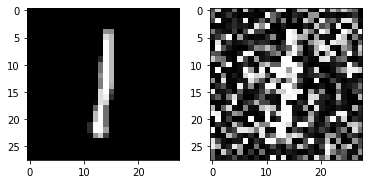

25  :  -0.4321867410173339 25
50  :  -0.21074543711155333 25
75  :  -0.12508353163128047 25
100  :  0.2131447064152542 25
125  :  0.359516590106203 25
150  :  0.4095979950892979 25
175  :  0.42513781660880196 25
200  :  0.42513781660880196 25
225  :  0.4456340879736318 25
250  :  0.45839376026434464 25
275  :  0.45983952393724253 25
300  :  0.46533795469033745 25
325  :  0.46533795469033745 25
350  :  0.46533795469033745 25
375  :  0.46881725317996936 25
400  :  0.4769751248587155 25
425  :  0.4809981876618874 25
450  :  0.48160925077399036 25
475  :  0.48601890270355125 25
500  :  0.48940428209078896 25
525  :  0.4900227385101315 25
550  :  0.4900227385101315 25
575  :  0.49107694173768107 25
600  :  0.4915626967242075 25
625  :  0.4918361151324824 25
650  :  0.4918361151324824 25
675  :  0.49208054814511604 25
700  :  0.4928051765961347 25
725  :  0.4929949889334745 25
750  :  0.49416442633841867 25
775  :  0.4944293217085269 25
800  :  0.494502926251332 25
825  :  0.4947940370554012

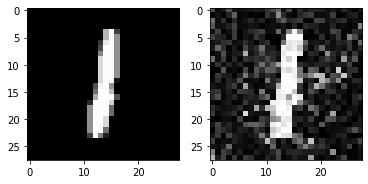

25  :  -0.48647393547797885 25
50  :  -0.4561690050996093 25
75  :  -0.3603126082204966 25
100  :  -0.2250984452583578 25
125  :  0.20806525937597392 25
150  :  0.3497814727949812 25
175  :  0.37819096869397606 25
200  :  0.3969600541954635 25
225  :  0.40001977302218633 25
250  :  0.40508973331640225 25
275  :  0.426572809833951 25
300  :  0.42909506154658705 25
325  :  0.44332335476728313 25
350  :  0.4523075890842031 25
375  :  0.4563655258434887 25
400  :  0.4636146609291708 25
425  :  0.4698722394586674 25
450  :  0.4762489827933904 25
475  :  0.48065806492092644 25
500  :  0.4811585646349092 25
525  :  0.4835207101058197 25
550  :  0.4834991688647289 25
575  :  0.48429274361123903 25
600  :  0.48551451194332995 25
625  :  0.48667609130777906 25
650  :  0.48667609130777906 25
675  :  0.4869263735102533 25
700  :  0.4876795104011709 25
725  :  0.488451902427694 25
750  :  0.48893472565289847 25
775  :  0.490128451933843 25
800  :  0.49023685632167374 25
825  :  0.4904306249083224 2

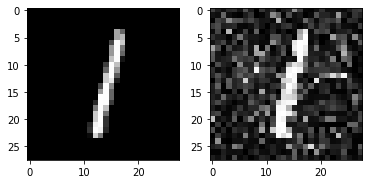

25  :  -0.4516246754293828 25
50  :  0.002870312390846394 25
75  :  -0.1036366183417044 25
100  :  0.20207765241813927 25
125  :  0.28840563454123086 25
150  :  0.3909901819938271 25
175  :  0.3961528215259683 25
200  :  0.4321123122003758 25
225  :  0.44395130665067034 25
250  :  0.43039647400424214 25
275  :  0.4248887307650395 25
300  :  0.4389876212333679 25
325  :  0.4389876212333679 25
350  :  0.4427479711574672 25
375  :  0.4427479711574672 25
400  :  0.45268977242498953 25
425  :  0.4650661178582165 25
450  :  0.4647596472274961 25
475  :  0.4647596472274961 25
500  :  0.4660625785548825 25
525  :  0.47493972954092173 25
550  :  0.478344856932505 25
575  :  0.48263021773912523 25
600  :  0.4841775290737973 25
625  :  0.4842898360507708 25
650  :  0.4842898360507708 25
675  :  0.4842898360507708 25
700  :  0.4861090412017707 25
725  :  0.4867687893698915 25
750  :  0.48720606116606696 25
775  :  0.4882008929572234 25
800  :  0.4881989882124541 25
825  :  0.4881989882124541 25
85

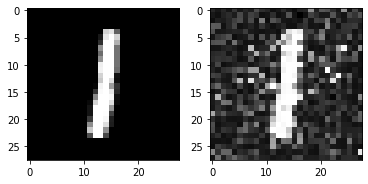

25  :  -0.36527001004029047 25
50  :  -0.2866353613072458 25
75  :  -0.01748753692897532 25
100  :  0.22422240844886068 25
125  :  0.28286629110853806 25
150  :  0.39001779939838455 25
175  :  0.3947090470123132 25
200  :  0.4215110139340716 25
225  :  0.4276308214794618 25
250  :  0.4281132199255186 25
275  :  0.43994697765243945 25
300  :  0.4558604515821105 25
325  :  0.4558604515821105 25
350  :  0.46079275354387544 25
375  :  0.46776958690421944 25
400  :  0.4730989227867874 25
425  :  0.4762682871188135 25
450  :  0.4798207179819583 25
475  :  0.481647707661985 25
500  :  0.4835789121848921 25
525  :  0.48495060472776025 25
550  :  0.48688135229369306 25
575  :  0.48727534822621527 25
600  :  0.4875080312764445 25
625  :  0.48987246104498006 25
650  :  0.49015489624615466 25
675  :  0.4904050935379179 25
700  :  0.4906441364410087 25
725  :  0.49117256770376033 25
750  :  0.4921364319583186 25
775  :  0.49249403666346014 25
800  :  0.49348307221211307 25
825  :  0.493493710737295

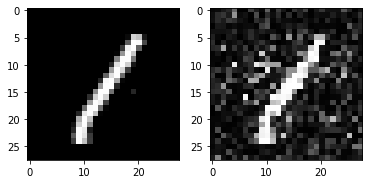

25  :  -0.46631131942116244 25
50  :  -0.3818756796496007 25
75  :  -0.3141555052626602 25
100  :  -0.15793117195161158 25
125  :  0.15904238427720127 25
150  :  0.3252695507564624 25
175  :  0.36742214275103824 25
200  :  0.33797254444563546 25
225  :  0.3617561611872232 25
250  :  0.40911750874407804 25
275  :  0.44773594440638664 25
300  :  0.4221509983576216 25
325  :  0.4261917086213237 25
350  :  0.43045711345367565 25
375  :  0.4317259607805504 25
400  :  0.4380583757454637 25
425  :  0.4540078533582196 25
450  :  0.45782147815833857 25
475  :  0.45817776136195815 25
500  :  0.46283450583958213 25
525  :  0.4594178261338848 25
550  :  0.45988112153013566 25
575  :  0.4641047545345869 25
600  :  0.47224805664820985 25
625  :  0.4721465460209304 25
650  :  0.47535695947979417 25
675  :  0.475663422742694 25
700  :  0.4779229132319894 25
725  :  0.4788809996242404 25
750  :  0.4811215855638492 25
775  :  0.4810947536793454 25
800  :  0.4817196075784349 25
825  :  0.4868523672570874

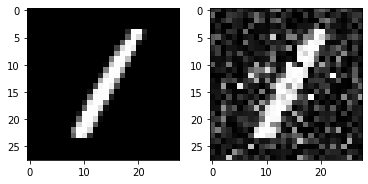

25  :  -0.47044631501835193 25
50  :  0.085063552713524 25
75  :  -0.29810033698129956 25
100  :  -0.4531412655773655 25
125  :  -0.26854670004353304 25
150  :  -0.3499449505295482 25
175  :  -0.05820913731871362 25
200  :  -0.11593536696014928 25
225  :  0.2743125953399445 25
250  :  0.40700801232488043 25
275  :  0.47679584638850275 25
300  :  0.4827323219764329 25
325  :  0.48291503948168035 25
350  :  0.48395767329820455 25
375  :  0.4836059958675571 25
400  :  0.482397891460393 25
425  :  0.48289005951047803 25
450  :  0.4838388123696675 25
475  :  0.48403413650884386 25
500  :  0.48434172290067334 25
525  :  0.48582692981731124 25
550  :  0.4863381951940059 25
575  :  0.48623968925180994 25
600  :  0.4867494008768449 25
625  :  0.4871549627400984 25
650  :  0.48731101605356353 25
675  :  0.48750834335805654 25
700  :  0.48748495224076993 25
725  :  0.48774555334282305 25
750  :  0.48812965819145615 25
775  :  0.48829945038976813 25
800  :  0.4883391648442666 25
825  :  0.48844835

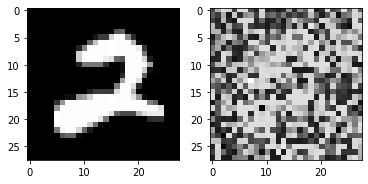

25  :  -0.4616095103823396 25
50  :  0.07116142866169954 25
75  :  -0.3035247464211003 25
100  :  -0.17590566984191816 25
125  :  0.006344200226183093 25
150  :  0.26828575469623617 25
175  :  0.43988514704168213 25
200  :  0.4716527196170682 25
225  :  0.47354443281869074 25
250  :  0.478170679804391 25
275  :  0.47985108951364314 25
300  :  0.48052750716457254 25
325  :  0.4802161133971036 25
350  :  0.481446102348939 25
375  :  0.4810150132294974 25
400  :  0.4815555407325005 25
425  :  0.48195665906800605 25
450  :  0.4826426175005256 25
475  :  0.48317219939372913 25
500  :  0.4835496242916694 25
525  :  0.48424846189052184 25
550  :  0.48450853626293194 25
575  :  0.48463055306738184 25
600  :  0.4848520819199914 25
625  :  0.4844796309986611 25
650  :  0.4847858791331109 25
675  :  0.4850219515698876 25
700  :  0.4849535637435455 25
725  :  0.4851470096999979 25
750  :  0.4855290185049559 25
775  :  0.4856496795855031 25
800  :  0.48548082635261935 25
825  :  0.48586306701406307

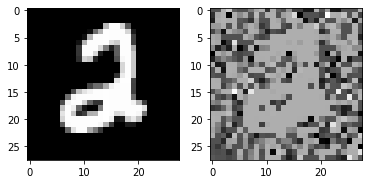

25  :  -0.27633504496305317 25
50  :  -0.26261277867775684 25
75  :  -0.25369146658794584 25
100  :  -0.21133497173131713 25
125  :  -0.1805724230195843 25
150  :  -0.1754855492792173 25
175  :  -0.02069418315878856 25
200  :  -0.01078714296924775 25
225  :  0.08230636175509724 25
250  :  0.22039776845707337 25
275  :  0.21645966483307233 25
300  :  0.4461762455104702 25
325  :  0.48115456266135087 25
350  :  0.4862566621816005 25
375  :  0.48681105870465924 25
400  :  0.4877032619499048 25
425  :  0.4881524053347364 25
450  :  0.48763535402024394 25
475  :  0.4884182262820549 25
500  :  0.48838315973678 25
525  :  0.48887516383936547 25
550  :  0.48901867741037436 25
575  :  0.4893466811956136 25
600  :  0.4891864927628049 25
625  :  0.4892994524051376 25
650  :  0.4893710681211138 25
675  :  0.4896426184747142 25
700  :  0.4897361024241634 25
725  :  0.48972593388908736 25
750  :  0.4897984353934827 25
775  :  0.4898602177781274 25
800  :  0.4898470717656656 25
825  :  0.489874637374

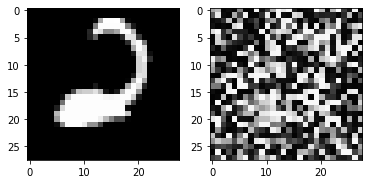

25  :  -0.4539386526921135 25
50  :  -0.40641114780860904 25
75  :  -0.41305305720106816 25
100  :  -0.3375314861589394 25
125  :  -0.3154282489334405 25
150  :  -0.1694075190473353 25
175  :  0.23480136521962292 25
200  :  0.33057684363291745 25
225  :  0.3498769008982708 25
250  :  0.44484650678813653 25
275  :  0.46466365507149543 25
300  :  0.4469631312043264 25
325  :  0.4714357932818734 25
350  :  0.4589274061895987 25
375  :  0.4687870400639225 25
400  :  0.4724086853781085 25
425  :  0.4724086853781085 25
450  :  0.47406398130051647 25
475  :  0.47457951264723014 25
500  :  0.47716054627726007 25
525  :  0.4755899831181981 25
550  :  0.48014850115336155 25
575  :  0.4802577377969415 25
600  :  0.4802577377969415 25
625  :  0.4811230026855252 25
650  :  0.48248938881170356 25
675  :  0.48213724383549156 25
700  :  0.4822859650914475 25
725  :  0.4834192659281234 25
750  :  0.4829646140813653 25
775  :  0.4842299092004344 25
800  :  0.4845706204914913 25
825  :  0.485728047587334

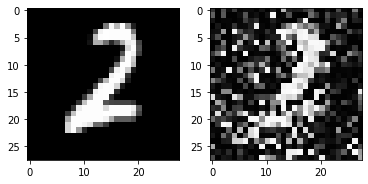

25  :  0.2535521216134035 25
50  :  0.47391185656626234 25
75  :  0.4315326146553157 25
100  :  0.43140776497507227 25
125  :  0.468234847013063 25
150  :  0.4704203802268429 25
175  :  0.4890979240104505 25
200  :  0.48606866425066364 25
225  :  0.48773291736070357 25
250  :  0.489244766887778 25
275  :  0.4880216262127012 25
300  :  0.4884884843764817 25
325  :  0.4891710499951085 25
350  :  0.4886242818524117 25
375  :  0.48901274706020587 25
400  :  0.4888823232079549 25
425  :  0.4897758398352186 25
450  :  0.4898980224478741 25
475  :  0.48994441291116697 25
500  :  0.4900612123384116 25
525  :  0.4906911552304117 25
550  :  0.4906613479453159 25
575  :  0.4907809412495178 25
600  :  0.490845848526585 25
625  :  0.49090592409029987 25
650  :  0.49090984552803296 25
675  :  0.49104765001880935 25
700  :  0.4910424625787305 25
725  :  0.4911075979154194 25
750  :  0.49110761758472943 25
775  :  0.49116616405217356 25
800  :  0.49129511059249503 25
825  :  0.49133304254083443 25
850

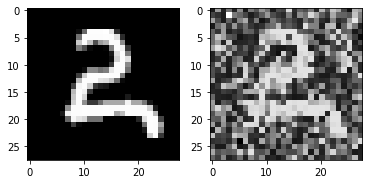

25  :  -0.0429753241969619 25
50  :  0.11501386363783271 25
75  :  0.15114987239762911 25
100  :  0.2804250773121985 25
125  :  0.295015948660803 25
150  :  0.3954796122551343 25
175  :  0.4119464573993042 25
200  :  0.45634633328045227 25
225  :  0.4594775081739817 25
250  :  0.47153973271532984 25
275  :  0.47545675792604397 25
300  :  0.47545675792604397 25
325  :  0.47873989317047216 25
350  :  0.4846499129367279 25
375  :  0.48485227675594156 25
400  :  0.48674903925423596 25
425  :  0.48674903925423596 25
450  :  0.4870256396441185 25
475  :  0.48780279723060305 25
500  :  0.48872516025662005 25
525  :  0.48974637442399044 25
550  :  0.490716702318891 25
575  :  0.490716702318891 25
600  :  0.4913531379971451 25
625  :  0.4919346621260779 25
650  :  0.4922883477615217 25
675  :  0.49252835930738886 25
700  :  0.492788780430233 25
725  :  0.49278900988480895 25
750  :  0.49307291304457707 25
775  :  0.49324298380342924 25
800  :  0.49387225959120534 25
825  :  0.49424313445724644 

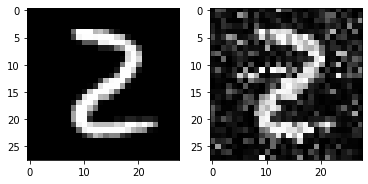

25  :  -0.3600387738056195 25
50  :  0.42075683455719143 25
75  :  -0.03602374113064677 25
100  :  0.3159825543675956 25
125  :  0.35515597854672054 25
150  :  0.4283178434947498 25
175  :  0.46007258388787836 25
200  :  0.4763383219491091 25
225  :  0.4768000635712149 25
250  :  0.4790703875610822 25
275  :  0.47942526943305636 25
300  :  0.4803394524411859 25
325  :  0.48086356016799436 25
350  :  0.4814648979144217 25
375  :  0.48182805272228035 25
400  :  0.4819248710436421 25
425  :  0.48225303631923094 25
450  :  0.4835919465076789 25
475  :  0.484221695279689 25
500  :  0.4849213480111687 25
525  :  0.4856708472333783 25
550  :  0.4862970895628021 25
575  :  0.486492584849118 25
600  :  0.48691743363740364 25
625  :  0.487127757976145 25
650  :  0.48735798646855016 25
675  :  0.4878832313686287 25
700  :  0.4882181837349033 25
725  :  0.4884717434235345 25
750  :  0.48861762901686445 25
775  :  0.48864316484323994 25
800  :  0.4887161545544555 25
825  :  0.4887625567846234 25
85

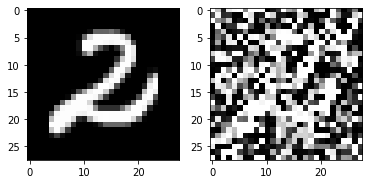

25  :  -0.19261378704820983 25
50  :  0.05165324674859835 25
75  :  -0.13921211363677655 25
100  :  -0.0018134676641494698 25
125  :  0.02897121875814247 25
150  :  0.1189990200488305 25
175  :  0.28290578583827947 25
200  :  0.34987907126225826 25
225  :  0.4154622504029924 25
250  :  0.469419581207495 25
275  :  0.46934784481378145 25
300  :  0.4786610170560016 25
325  :  0.4832628227507319 25
350  :  0.48238749022895705 25
375  :  0.48283127909247464 25
400  :  0.48293374101250314 25
425  :  0.483204506976479 25
450  :  0.4830304615879097 25
475  :  0.48367856889056177 25
500  :  0.48458629171342416 25
525  :  0.48522947433664476 25
550  :  0.4852379687579589 25
575  :  0.48576222209922726 25
600  :  0.48597237055492354 25
625  :  0.486429341837713 25
650  :  0.4865482433779841 25
675  :  0.4871804769548215 25
700  :  0.48733100683778513 25
725  :  0.4878258974107249 25
750  :  0.48774456059496074 25
775  :  0.48794488588460444 25
800  :  0.48814035625716473 25
825  :  0.48814035625

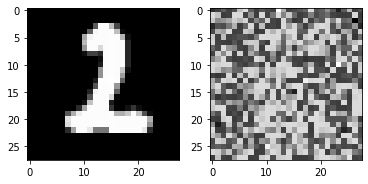

25  :  -0.4421183942963391 25
50  :  -0.034059433944404464 25
75  :  -0.38313332906876113 25
100  :  -0.39438878954180023 25
125  :  -0.21770335605197255 25
150  :  -0.06991111880915167 25
175  :  0.16387407832866954 25
200  :  0.42691382509638426 25
225  :  0.46702986275530206 25
250  :  0.4792064018489344 25
275  :  0.4803021918053979 25
300  :  0.4800910937637555 25
325  :  0.47996928361867547 25
350  :  0.48123642429337726 25
375  :  0.48153314111401097 25
400  :  0.4834128021652674 25
425  :  0.4846117247617744 25
450  :  0.48542253872083607 25
475  :  0.48530565162991673 25
500  :  0.4853607263003515 25
525  :  0.48528253688184103 25
550  :  0.4851503260938639 25
575  :  0.4852105987637403 25
600  :  0.48546662336882057 25
625  :  0.485343834880041 25
650  :  0.48554591979183914 25
675  :  0.4854961353787847 25
700  :  0.4858261464841634 25
725  :  0.4860925649058264 25
750  :  0.48597286001611406 25
775  :  0.4861258522876995 25
800  :  0.486341831901744 25
825  :  0.48636352146

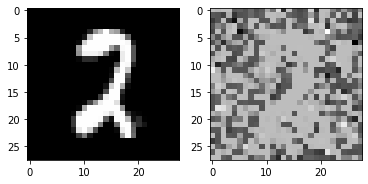

25  :  -0.38738925449417705 25
50  :  -0.3758717018014867 25
75  :  -0.31818293737964 25
100  :  -0.26609846857310976 25
125  :  -0.18803167799510695 25
150  :  -0.028699544370014853 25
175  :  0.18111654422102405 25
200  :  0.27399395717067365 25
225  :  0.35059337180869865 25
250  :  0.3937963732382058 25
275  :  0.3988076634227972 25
300  :  0.4354618253556928 25
325  :  0.42599614080370446 25
350  :  0.46412321148833374 25
375  :  0.4569857047981115 25
400  :  0.4569857047981115 25
425  :  0.46611415938159156 25
450  :  0.4713909507918574 25
475  :  0.4724713423060948 25
500  :  0.48222268359833625 25
525  :  0.4826397924393533 25
550  :  0.4822022046350683 25
575  :  0.4825504137981889 25
600  :  0.4821455242657686 25
625  :  0.48400484795203735 25
650  :  0.4884032689605772 25
675  :  0.4881683747214239 25
700  :  0.4886635891587497 25
725  :  0.4894212498018559 25
750  :  0.49016367314785775 25
775  :  0.49059315233039313 25
800  :  0.49090860778417805 25
825  :  0.4908156963119

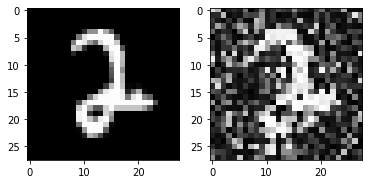

25  :  -0.46068155611266337 25
50  :  0.41967870736380586 25
75  :  -0.3966655345254204 25
100  :  -0.41156897714940854 25
125  :  -0.33450061487826327 25
150  :  -0.32052634703960087 25
175  :  -0.3827351526883369 25
200  :  -0.011649633535154705 25
225  :  -0.1312676569116989 25
250  :  0.4022805183932487 25
275  :  0.4781307881297275 25
300  :  0.48723096925039555 25
325  :  0.4878239271113861 25
350  :  0.4876306778194512 25
375  :  0.48774547599199036 25
400  :  0.48812456413615796 25
425  :  0.48867417524079804 25
450  :  0.4885862048799022 25
475  :  0.4889582707903516 25
500  :  0.4892535121636156 25
525  :  0.48952225789551423 25
550  :  0.4894204148582216 25
575  :  0.489296336810782 25
600  :  0.48941195711115737 25
625  :  0.4898091106804423 25
650  :  0.48971242322573694 25
675  :  0.48999742529195855 25
700  :  0.4901718491573227 25
725  :  0.49039129863016495 25
750  :  0.49023574498960854 25
775  :  0.49037604461094464 25
800  :  0.49046624708538916 25
825  :  0.4905271

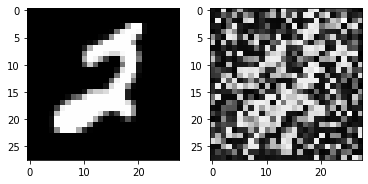

25  :  0.21638170546777483 25
50  :  0.21638170546777483 25
75  :  0.37878742075199456 25
100  :  0.3680897485568228 25
125  :  0.39924998088929786 25
150  :  0.42870806127993305 25
175  :  0.4465408972833841 25
200  :  0.41943404719782174 25
225  :  0.45963646193601193 25
250  :  0.45004942040938034 25
275  :  0.4504122112240209 25
300  :  0.45758846031174505 25
325  :  0.4607009422401606 25
350  :  0.4579344259871409 25
375  :  0.4576365051399172 25
400  :  0.4630125818275843 25
425  :  0.4680988976537012 25
450  :  0.47541181996527354 25
475  :  0.47353734267388087 25
500  :  0.47259965432908807 25
525  :  0.48270849263717563 25
550  :  0.4832342505547697 25
575  :  0.4835955078642083 25
600  :  0.4839043866460322 25
625  :  0.48334684692220736 25
650  :  0.48363992897476366 25
675  :  0.4844282578374793 25
700  :  0.4847171789631037 25
725  :  0.48621374842457776 25
750  :  0.4864149326352374 25
775  :  0.48819680935425463 25
800  :  0.4887015169498485 25
825  :  0.4894323137381952

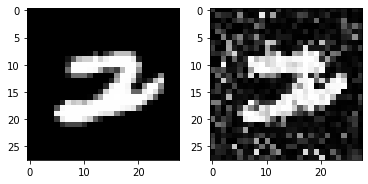

25  :  -0.0864909382844488 25
50  :  0.47103056355028305 25
75  :  0.405142160282645 25
100  :  0.4653683856874127 25
125  :  0.43893180239423907 25
150  :  0.47108218445525013 25
175  :  0.48511320545032244 25
200  :  0.4820554052086291 25
225  :  0.4876559179716614 25
250  :  0.4872814926800093 25
275  :  0.4891597465975752 25
300  :  0.4904057339997552 25
325  :  0.4901432495721023 25
350  :  0.49068939427861424 25
375  :  0.4907561489830184 25
400  :  0.49079979759486075 25
425  :  0.4917551856501786 25
450  :  0.49164095993685136 25
475  :  0.49178909001231036 25
500  :  0.4919913868994721 25
525  :  0.4919779199339061 25
550  :  0.49209414291187215 25
575  :  0.4922191636823688 25
600  :  0.49217525104272536 25
625  :  0.49216667975298567 25
650  :  0.49243094219807343 25
675  :  0.4925482437032014 25
700  :  0.49269142749786726 25
725  :  0.4927022640102031 25
750  :  0.4927022640102031 25
775  :  0.4927022640102031 25
800  :  0.4927022640102031 25
825  :  0.4927145553042245 25


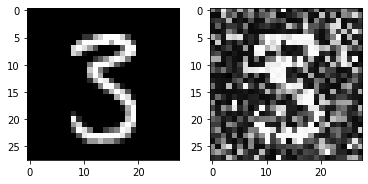

25  :  -0.3362439619818629 25
50  :  0.4219217209427926 25
75  :  0.15112362952461275 25
100  :  0.08676506591646918 25
125  :  0.2657191541107594 25
150  :  0.34149783005846274 25
175  :  0.4233246462422145 25
200  :  0.4667897538806549 25
225  :  0.479290196700738 25
250  :  0.4808208242372252 25
275  :  0.4821290155630451 25
300  :  0.48005945701068237 25
325  :  0.48138464851826956 25
350  :  0.48308370500385683 25
375  :  0.4847599922466471 25
400  :  0.4849917259872358 25
425  :  0.4845434323556562 25
450  :  0.48432340380510164 25
475  :  0.48426738705818717 25
500  :  0.48579531520746955 25
525  :  0.4866162105703147 25
550  :  0.4874195013425326 25
575  :  0.488316826258947 25
600  :  0.4879563554725598 25
625  :  0.48808490871879745 25
650  :  0.4881384851857018 25
675  :  0.4887211318966535 25
700  :  0.4887211318966535 25
725  :  0.4888602931332732 25
750  :  0.4888840424080032 25
775  :  0.48902539170117854 25
800  :  0.4890272523103497 25
825  :  0.4890272523103497 25
850

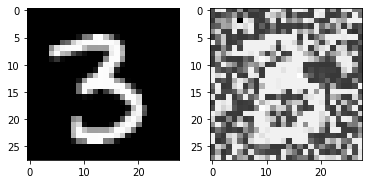

25  :  -0.42732467256739604 25
50  :  0.278872291562956 25
75  :  0.1082382264282046 25
100  :  0.0007945324351426837 25
125  :  0.2160602612915874 25
150  :  0.1804340090694735 25
175  :  0.3533072170701263 25
200  :  0.4309545218148746 25
225  :  0.46001039954092937 25
250  :  0.48615925774552465 25
275  :  0.48561002963999966 25
300  :  0.4847815537989895 25
325  :  0.4849247464720333 25
350  :  0.48552051447072214 25
375  :  0.4840557541263896 25
400  :  0.48523669293122185 25
425  :  0.4862084940104502 25
450  :  0.48714507618524017 25
475  :  0.4876415472605767 25
500  :  0.487961089238487 25
525  :  0.48844285962284306 25
550  :  0.48924550870329964 25
575  :  0.4892925227996506 25
600  :  0.4897901801709981 25
625  :  0.48981695299740896 25
650  :  0.4898233679672441 25
675  :  0.49000370042157354 25
700  :  0.4901231354601736 25
725  :  0.4900921861212713 25
750  :  0.490162594513577 25
775  :  0.4903129614311263 25
800  :  0.4903229768477502 25
825  :  0.4903229768477502 25
8

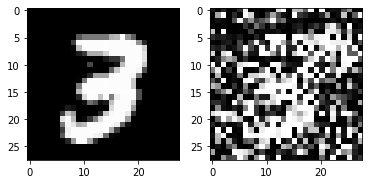

25  :  -0.16284701159779974 25
50  :  0.3678257998203021 25
75  :  0.1719672244261712 25
100  :  0.38430811662780856 25
125  :  0.4261042932424137 25
150  :  0.45276263935286726 25
175  :  0.4702661073770866 25
200  :  0.4782409662566561 25
225  :  0.4792985556439675 25
250  :  0.48008748443500343 25
275  :  0.48055070964394014 25
300  :  0.4811503525661932 25
325  :  0.47968932884289106 25
350  :  0.481106124991608 25
375  :  0.48225807549939304 25
400  :  0.4830522053340367 25
425  :  0.48416235997168267 25
450  :  0.4849652994067052 25
475  :  0.4852358428434111 25
500  :  0.48576041678587734 25
525  :  0.4861489632037131 25
550  :  0.48673081380301975 25
575  :  0.48729131221777505 25
600  :  0.48698554200074373 25
625  :  0.4871976904737888 25
650  :  0.4872406963297704 25
675  :  0.4876788495535657 25
700  :  0.4875366459171351 25
725  :  0.4879747047652493 25
750  :  0.48806162182771734 25
775  :  0.488656719044404 25
800  :  0.4883164858168939 25
825  :  0.4883691708035091 25
8

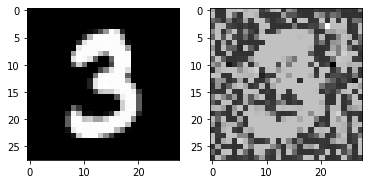

25  :  -0.2549800233621544 25
50  :  0.19614279576283544 25
75  :  0.08754702467172618 25
100  :  0.24413768815489492 25
125  :  0.39169585040218136 25
150  :  0.3976277972015039 25
175  :  0.44937690947424774 25
200  :  0.4637601587809649 25
225  :  0.47922773260619655 25
250  :  0.47853942324243054 25
275  :  0.48055214122879514 25
300  :  0.48021483458959696 25
325  :  0.4808516519437086 25
350  :  0.4829928374805568 25
375  :  0.48335140670439186 25
400  :  0.4833440905492282 25
425  :  0.48494211508337526 25
450  :  0.48540503214508796 25
475  :  0.4859146922935351 25
500  :  0.48590956258972434 25
525  :  0.48646960760924884 25
550  :  0.4866529411964524 25
575  :  0.4870226437620985 25
600  :  0.48718112055139723 25
625  :  0.4877252248272393 25
650  :  0.4877350558301839 25
675  :  0.48798861423797973 25
700  :  0.48684220271204737 25
725  :  0.48721794130905804 25
750  :  0.4878296570479917 25
775  :  0.4878966513668551 25
800  :  0.48785595962749123 25
825  :  0.4880433436422

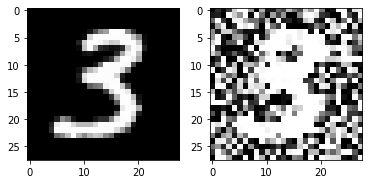

25  :  -0.2589008860734998 25
50  :  0.34101944092705544 25
75  :  0.08600907282587303 25
100  :  0.09678646434196025 25
125  :  0.3109947269875868 25
150  :  0.42253205265649674 25
175  :  0.46627130937867556 25
200  :  0.4817517130339099 25
225  :  0.4836435465492994 25
250  :  0.48481773871725026 25
275  :  0.483718418649254 25
300  :  0.4847654592222238 25
325  :  0.48627133678536794 25
350  :  0.48598540449146405 25
375  :  0.48743705179110597 25
400  :  0.4878104824084535 25
425  :  0.4877934683642027 25
450  :  0.48815935372424685 25
475  :  0.48823928533962146 25
500  :  0.48888958492511103 25
525  :  0.4888469718512678 25
550  :  0.48920394932091915 25
575  :  0.4889573494855 25
600  :  0.4888367718440063 25
625  :  0.4891520667123058 25
650  :  0.48903969832190597 25
675  :  0.489250736556529 25
700  :  0.48943314833900786 25
725  :  0.48936705901422406 25
750  :  0.4893303061089251 25
775  :  0.48937610828628936 25
800  :  0.4894581440582651 25
825  :  0.4896416066572513 25


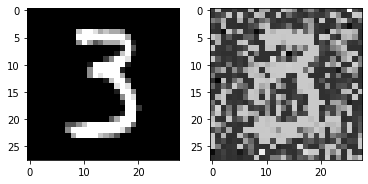

25  :  -0.4925556218046806 25
50  :  -0.255480805405048 25
75  :  -0.3919189143699648 25
100  :  -0.41713056665715414 25
125  :  -0.3860306465269843 25
150  :  -0.4530811180980602 25
175  :  -0.4843832487092992 25
200  :  -0.0684873254081486 25
225  :  -0.3992057722329511 25
250  :  0.1677742408515801 25
275  :  0.373058426684374 25
300  :  0.47525125585271366 25
325  :  0.48265988308561025 25
350  :  0.48375289262366744 25
375  :  0.4840039011331543 25
400  :  0.4844518015911028 25
425  :  0.4849952991463083 25
450  :  0.48660859816548285 25
475  :  0.4877600858666701 25
500  :  0.48805721491760756 25
525  :  0.4892542701972414 25
550  :  0.4893317250073047 25
575  :  0.4893317250073047 25
600  :  0.4895562253116299 25
625  :  0.4898419657225864 25
650  :  0.48985563146664235 25
675  :  0.4900350377950326 25
700  :  0.4900089504669765 25
725  :  0.49005203060220426 25
750  :  0.4901087555824071 25
775  :  0.49029982961868596 25
800  :  0.4903604110309281 25
825  :  0.49050111509435435

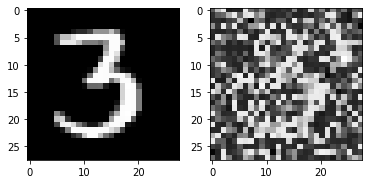

25  :  -0.48754581640494243 25
50  :  -0.10251053088421014 25
75  :  -0.3552533139252695 25
100  :  -0.21498008485546363 25
125  :  0.03326502794113304 25
150  :  -0.010424958657301826 25
175  :  0.3045727668366575 25
200  :  0.4162181401827753 25
225  :  0.4606308211862067 25
250  :  0.48107586183878676 25
275  :  0.48041540806499405 25
300  :  0.4821909067094402 25
325  :  0.48347722824554984 25
350  :  0.48244122522030863 25
375  :  0.4831042268340429 25
400  :  0.48245578432540864 25
425  :  0.4842878149051352 25
450  :  0.48537532934885136 25
475  :  0.4850795946574778 25
500  :  0.4854253128644507 25
525  :  0.4857561821736046 25
550  :  0.4858976757366333 25
575  :  0.4856748655175546 25
600  :  0.4853025366376627 25
625  :  0.48595514474146084 25
650  :  0.4864591594920583 25
675  :  0.4866102914545828 25
700  :  0.48704765932077076 25
725  :  0.4871364942580671 25
750  :  0.48727568323980813 25
775  :  0.487895180381004 25
800  :  0.48764764478422573 25
825  :  0.4878495017893

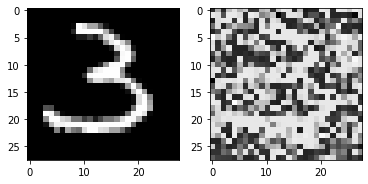

25  :  0.4880516948678926 25
50  :  0.4890533392359964 25
75  :  0.48901020826622654 25
100  :  0.4869811795031377 25
125  :  0.4872619349816017 25
150  :  0.49049847773190125 25
175  :  0.48946622186672023 25
200  :  0.48776337613599857 25
225  :  0.48800622603708776 25
250  :  0.4876788601106321 25
275  :  0.4886389700779218 25
300  :  0.4915563057183386 25
325  :  0.49028314491300223 25
350  :  0.49186308831970105 25
375  :  0.4919353423705414 25
400  :  0.49183745301559284 25
425  :  0.4921832668538961 25
450  :  0.4921044775588293 25
475  :  0.49188591376113794 25
500  :  0.4920454605245701 25
525  :  0.49189803061703113 25
550  :  0.49203611430613137 25
575  :  0.4921391261785277 25
600  :  0.49220405088440394 25
625  :  0.49237193454421896 25
650  :  0.49252432032942445 25
675  :  0.4928025116542577 25
700  :  0.49284402349628903 25
725  :  0.49283879630312355 25
750  :  0.49293310401390594 25
775  :  0.49302183089579743 25
800  :  0.493064960092886 25
Time:  100.83306932449341 

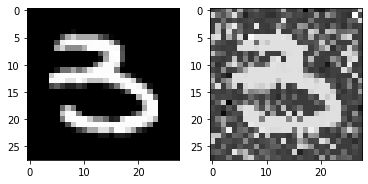

25  :  -0.14066260918315387 25
50  :  -0.09010351937587768 25
75  :  -0.02032545195416123 25
100  :  -0.0010094686236891176 25
125  :  0.05749708063465764 25
150  :  0.0011743083711621275 25
175  :  0.05211318459736611 25
200  :  0.1718547868405562 25
225  :  0.26398305846151676 25
250  :  0.38461863586102957 25
275  :  0.43316278100583977 25
300  :  0.4336708032936747 25
325  :  0.47114536007415686 25
350  :  0.47097775515509227 25
375  :  0.47097775515509227 25
400  :  0.48502011164186287 25
425  :  0.48534084206921396 25
450  :  0.4901686138374404 25
475  :  0.48904243576183787 25
500  :  0.4903755696075291 25
525  :  0.49019667490264707 25
550  :  0.4912218988930658 25
575  :  0.4912224449945892 25
600  :  0.4916571549716549 25
625  :  0.49243589665886356 25
650  :  0.4929533233618184 25
675  :  0.4939594800066621 25
700  :  0.4940826958208372 25
725  :  0.49402206799160103 25
750  :  0.49407132526057435 25
775  :  0.49419171797049305 25
800  :  0.4944287891806768 25
825  :  0.4943

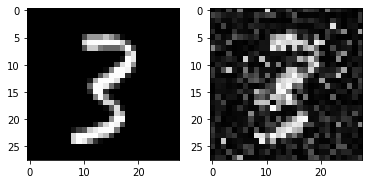

25  :  -0.3917239263705806 25
50  :  0.15390839090732136 25
75  :  -0.27059800125991146 25
100  :  -0.3300484766259658 25
125  :  -0.29098795719712345 25
150  :  -0.20786081190868763 25
175  :  -0.4309071558435045 25
200  :  -0.4000006461896097 25
225  :  -0.3810902831421914 25
250  :  0.2051940804711915 25
275  :  0.37062442635353904 25
300  :  0.46698305318201144 25
325  :  0.4816198279347196 25
350  :  0.48291721588870395 25
375  :  0.4833156556905016 25
400  :  0.4836121481857284 25
425  :  0.48221224042666133 25
450  :  0.48355472966703184 25
475  :  0.48412408640435645 25
500  :  0.48389447348346015 25
525  :  0.4840809811426092 25
550  :  0.48519784009887745 25
575  :  0.48658809513788953 25
600  :  0.48654244198805047 25
625  :  0.48684677510459895 25
650  :  0.4867834185800864 25
675  :  0.4872646743231162 25
700  :  0.4875932719419186 25
725  :  0.48746050559402954 25
750  :  0.4878110546211551 25
775  :  0.48787793467552415 25
800  :  0.4881028166522567 25
825  :  0.48824014

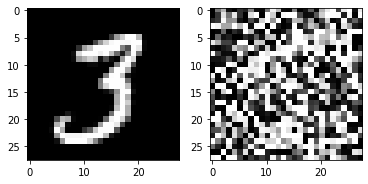

25  :  0.06188715531029841 25
50  :  0.4658800966534799 25
75  :  0.28207846255465385 25
100  :  0.4573541897597677 25
125  :  0.46667182852682104 25
150  :  0.4840816348693804 25
175  :  0.48576901770485 25
200  :  0.48549012650748047 25
225  :  0.4854009912657132 25
250  :  0.4870399934978111 25
275  :  0.4873882388732116 25
300  :  0.4880199930848639 25
325  :  0.48822670849187305 25
350  :  0.48935064481881363 25
375  :  0.4894459213961274 25
400  :  0.4894459213961274 25
425  :  0.48970412063681373 25
450  :  0.49026823104729605 25
475  :  0.490367532936668 25
500  :  0.49036524965833783 25
525  :  0.4905933949830084 25
550  :  0.4906710156213493 25
575  :  0.4908568514543345 25
600  :  0.4908428896312542 25
625  :  0.4908428896312542 25
650  :  0.49088827435953825 25
675  :  0.49091229122582386 25
700  :  0.4909651620131356 25
725  :  0.4910315243712743 25
750  :  0.49105829968488335 25
775  :  0.49107444921476756 25
800  :  0.49111225691886773 25
825  :  0.49111231671990163 25
8

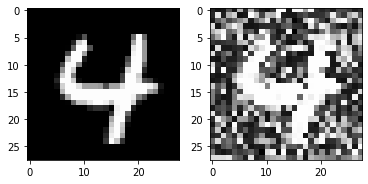

25  :  -0.034592334332618255 25
50  :  0.1976937953667079 25
75  :  0.2721627663486872 25
100  :  0.3466729818528188 25
125  :  0.4287587592562511 25
150  :  0.41362315598952504 25
175  :  0.4598550295652468 25
200  :  0.47262706639675006 25
225  :  0.4762835108971434 25
250  :  0.48010800576667595 25
275  :  0.4818275251654462 25
300  :  0.4805583067963412 25
325  :  0.48244154946992834 25
350  :  0.48220797667547416 25
375  :  0.4827439053737947 25
400  :  0.4830862994399401 25
425  :  0.48343531443697213 25
450  :  0.48403777433279216 25
475  :  0.48483846154708565 25
500  :  0.4855584999565432 25
525  :  0.48628790202569855 25
550  :  0.48640773170840435 25
575  :  0.48692958370563977 25
600  :  0.48738533685668417 25
625  :  0.48740382577779445 25
650  :  0.4875463810389727 25
675  :  0.487978706859083 25
700  :  0.4878461767842648 25
725  :  0.48780041469529817 25
750  :  0.4882339911388951 25
775  :  0.4884742321792015 25
800  :  0.48880831554368404 25
825  :  0.4889688547452517

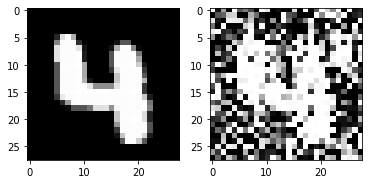

25  :  -0.08383395582786703 25
50  :  0.4476849794164221 25
75  :  0.02221904078486463 25
100  :  0.3557989875192873 25
125  :  0.39274418307675363 25
150  :  0.46377650206823645 25
175  :  0.4780391237795439 25
200  :  0.4801064942376058 25
225  :  0.48216327377246826 25
250  :  0.48327326056426706 25
275  :  0.4835503274580647 25
300  :  0.4842390060963195 25
325  :  0.4846178881772052 25
350  :  0.48516523100283815 25
375  :  0.4852119834201303 25
400  :  0.4859075600409187 25
425  :  0.4865649808831482 25
450  :  0.4873933896572498 25
475  :  0.48746755697230354 25
500  :  0.48735176476301134 25
525  :  0.48804235768599835 25
550  :  0.4880160571888002 25
575  :  0.48798331245733373 25
600  :  0.4884780366579628 25
625  :  0.4884205421692625 25
650  :  0.4886591272657151 25
675  :  0.488702327365588 25
700  :  0.48880673105975825 25
725  :  0.4889824305165863 25
750  :  0.4890693286035285 25
775  :  0.48913545192227204 25
800  :  0.4891538055463639 25
825  :  0.4892584997332305 25


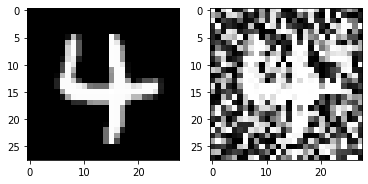

25  :  -0.39236472878348216 25
50  :  0.4312642961041352 25
75  :  0.37712355470575704 25
100  :  0.4609237592064403 25
125  :  0.48151862061641343 25
150  :  0.48603942999833183 25
175  :  0.4861119315978632 25
200  :  0.4864491888444066 25
225  :  0.48564375866798654 25
250  :  0.4839316748275601 25
275  :  0.4879416619536281 25
300  :  0.4870025155830129 25
325  :  0.48790729125599946 25
350  :  0.48816665534248455 25
375  :  0.4889131268903932 25
400  :  0.48887154095725216 25
425  :  0.4896074863392347 25
450  :  0.48957528986470367 25
475  :  0.48957528986470367 25
500  :  0.4895955285360143 25
525  :  0.49024534234411643 25
550  :  0.490196317090169 25
575  :  0.4906277022085608 25
600  :  0.4906494896829325 25
625  :  0.4906494896829325 25
650  :  0.4907122277433176 25
675  :  0.49069083158517823 25
700  :  0.49069083158517823 25
725  :  0.49082810766535606 25
750  :  0.4910061546989709 25
775  :  0.4909880113988757 25
800  :  0.49114239942066895 25
825  :  0.49116953827060217 

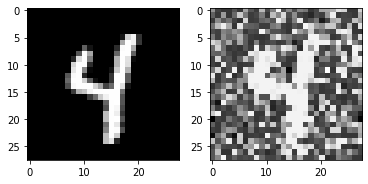

25  :  -0.004099221444693533 25
50  :  0.46793726014279374 25
75  :  0.2573269848363389 25
100  :  0.39066025216675704 25
125  :  0.47253034142278444 25
150  :  0.4793893475092122 25
175  :  0.48575409756787996 25
200  :  0.48859745313875746 25
225  :  0.48736539217184105 25
250  :  0.4892556177160643 25
275  :  0.4882659323748507 25
300  :  0.4888640562432084 25
325  :  0.48873909034774343 25
350  :  0.48873909034774343 25
375  :  0.48873909034774343 25
400  :  0.4891400513766702 25
425  :  0.4891019321554782 25
450  :  0.4894653480783576 25
475  :  0.48958207494791794 25
500  :  0.48958207494791794 25
525  :  0.48958207494791794 25
550  :  0.4898254415120306 25
575  :  0.4899077496029777 25
600  :  0.4900241496035763 25
625  :  0.4900543689205652 25
650  :  0.490185913874759 25
675  :  0.49032034128767943 25
700  :  0.490351433891036 25
725  :  0.49040612564498015 25
750  :  0.4905493266021384 25
775  :  0.49062764089946753 25
800  :  0.4906397255856535 25
825  :  0.490710167936058 2

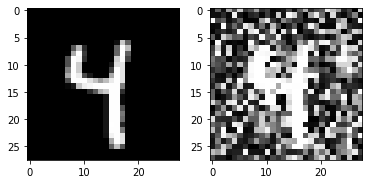

25  :  -0.24087677814941222 25
50  :  0.23062125954320295 25
75  :  0.0583982095240384 25
100  :  0.28032725450510515 25
125  :  0.38776917112937864 25
150  :  0.4301609597321411 25
175  :  0.4611159595850204 25
200  :  0.44386851486663975 25
225  :  0.4506545007387775 25
250  :  0.4733023261222469 25
275  :  0.48074446933513865 25
300  :  0.4847064718585849 25
325  :  0.4851790777764546 25
350  :  0.4854187399199573 25
375  :  0.4868494837040877 25
400  :  0.4881168807653793 25
425  :  0.4901267921948837 25
450  :  0.4904067113077919 25
475  :  0.4905756734016802 25
500  :  0.4904713052308081 25
525  :  0.49103773392291716 25
550  :  0.4918521478233124 25
575  :  0.49174762856046195 25
600  :  0.491845488364915 25
625  :  0.49222527676251526 25
650  :  0.4925300574694788 25
675  :  0.49258189399529007 25
700  :  0.4927152893566298 25
725  :  0.4927933655422321 25
750  :  0.49283415947083636 25
775  :  0.49277165255214816 25
800  :  0.4928321998457944 25
825  :  0.49284605298416206 25


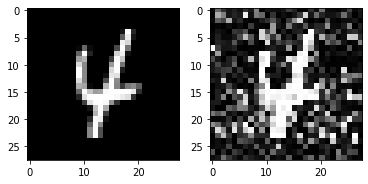

25  :  -0.43868910631162955 25
50  :  -0.019803665629960783 25
75  :  0.011422170407840505 25
100  :  0.3343143939386624 25
125  :  0.37441289981763276 25
150  :  0.46422055991199135 25
175  :  0.47870159875422025 25
200  :  0.48507716760104114 25
225  :  0.4873297963918628 25
250  :  0.48659396114103337 25
275  :  0.4874048483366167 25
300  :  0.48833796765132553 25
325  :  0.48854832138101645 25
350  :  0.48920457809672707 25
375  :  0.4890573781483185 25
400  :  0.4895856564973505 25
425  :  0.4899147307791034 25
450  :  0.4900555089867705 25
475  :  0.49015422136076514 25
500  :  0.4902316815060997 25
525  :  0.49044514965027886 25
550  :  0.4905704188533191 25
575  :  0.49069792119251743 25
600  :  0.49105104194451615 25
625  :  0.49109852724421005 25
650  :  0.49128574286434595 25
675  :  0.4913451841906238 25
700  :  0.49132358038030916 25
725  :  0.49146300809607624 25
750  :  0.4915021059779246 25
775  :  0.49163007967412675 25
800  :  0.49162623467064515 25
825  :  0.49166342

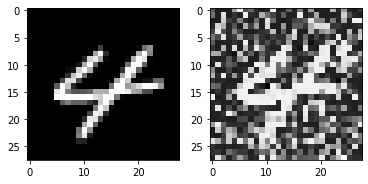

25  :  -0.0427152585635188 25
50  :  0.4577513539586575 25
75  :  0.18381728991696494 25
100  :  0.45029842119456126 25
125  :  0.4843030211742934 25
150  :  0.487532511061367 25
175  :  0.4889651975581979 25
200  :  0.489608377681587 25
225  :  0.48985759572389614 25
250  :  0.4905798916556222 25
275  :  0.4905766977420316 25
300  :  0.49161729023697354 25
325  :  0.4916491846698547 25
350  :  0.4916491846698547 25
375  :  0.4916491846698547 25
400  :  0.49213543726682707 25
425  :  0.49213543726682707 25
450  :  0.4922522006726447 25
475  :  0.49233240181803767 25
500  :  0.4924724274426397 25
525  :  0.4924724274426397 25
550  :  0.49248021590234703 25
575  :  0.4926103551592464 25
600  :  0.4926103551592464 25
625  :  0.4926103551592464 25
650  :  0.49263717035144433 25
675  :  0.49268392458450366 25
700  :  0.49267785633326605 25
725  :  0.49268329157223073 25
750  :  0.4927023843266333 25
775  :  0.4927064101126476 25
800  :  0.49271057473831814 25
825  :  0.4927209107423699 25
8

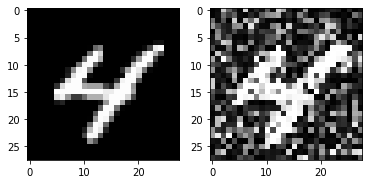

25  :  -0.19251281735051187 25
50  :  0.4353437780790266 25
75  :  0.43406779514115346 25
100  :  0.4827159265160861 25
125  :  0.49045391177406994 25
150  :  0.48983587555023184 25
175  :  0.4893659518541702 25
200  :  0.4893659518541702 25
225  :  0.4897441288922608 25
250  :  0.4902448104396434 25
275  :  0.4910069554873149 25
300  :  0.4910576203349881 25
325  :  0.4912594509145749 25
350  :  0.4913147099884148 25
375  :  0.4915884824113414 25
400  :  0.49157824157924507 25
425  :  0.49189855513775727 25
450  :  0.49191303078908555 25
475  :  0.49199097562036265 25
500  :  0.49199097562036265 25
525  :  0.4920286193627532 25
550  :  0.49220491661907273 25
575  :  0.4922587164915928 25
600  :  0.4923256352102886 25
625  :  0.4923139375445181 25
650  :  0.4924370503268958 25
675  :  0.49249860097772685 25
700  :  0.492556902157028 25
725  :  0.49264492149186656 25
750  :  0.4927159426237437 25
775  :  0.49273320090189 25
800  :  0.49273674047393345 25
825  :  0.49278148700331786 25
8

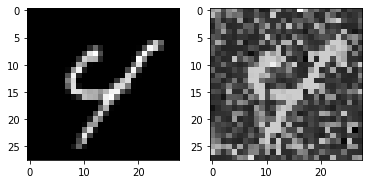

25  :  -0.4515373098224339 25
50  :  0.26213255811344055 25
75  :  -0.0013376441245480227 25
100  :  0.3728992495967992 25
125  :  0.47485987796367896 25
150  :  0.4839147880935359 25
175  :  0.4846882115288049 25
200  :  0.4844142933299856 25
225  :  0.4850139414348499 25
250  :  0.485369577549558 25
275  :  0.48523961358662165 25
300  :  0.4870408738621837 25
325  :  0.48679187829365744 25
350  :  0.487112021590471 25
375  :  0.4878099367429524 25
400  :  0.48807358519785665 25
425  :  0.4883815515636303 25
450  :  0.48833583871984787 25
475  :  0.48842015839166686 25
500  :  0.4892637897932839 25
525  :  0.4891720491420737 25
550  :  0.48949873286096274 25
575  :  0.4896015424450397 25
600  :  0.48992475762604687 25
625  :  0.48994370995413283 25
650  :  0.489946564809825 25
675  :  0.4901172664925795 25
700  :  0.4901730958983128 25
725  :  0.4903503546921692 25
750  :  0.49030730755117463 25
775  :  0.4903630266467107 25
800  :  0.4904233939593633 25
825  :  0.490423800379931 25
8

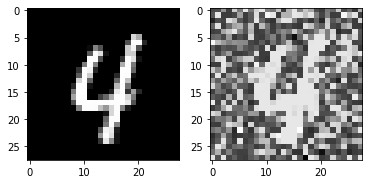

25  :  -0.34863876447970366 25
50  :  0.09633791157107616 25
75  :  0.12650344492778 25
100  :  0.12123315452538928 25
125  :  0.06573945560136958 25
150  :  0.44149084197184524 25
175  :  0.47232094186022316 25
200  :  0.480875740571971 25
225  :  0.4843429793436674 25
250  :  0.485018062693168 25
275  :  0.48643432391338515 25
300  :  0.48732043013245696 25
325  :  0.4882968169554066 25
350  :  0.4878150759139419 25
375  :  0.4887584056268289 25
400  :  0.48912033608582933 25
425  :  0.4899127656013482 25
450  :  0.4895782258081834 25
475  :  0.48991126515988564 25
500  :  0.4901220126156439 25
525  :  0.4901312228805592 25
550  :  0.4904416736069707 25
575  :  0.4904416736069707 25
600  :  0.4905238467779001 25
625  :  0.4907048992992512 25
650  :  0.49073719937482335 25
675  :  0.49075217339072696 25
700  :  0.4910006757585115 25
725  :  0.49110191979653883 25
750  :  0.4909650975985729 25
775  :  0.49106862636665594 25
800  :  0.4912338844058194 25
825  :  0.4912690339997636 25
85

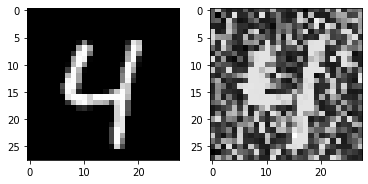

25  :  -0.11772106528506615 25
50  :  0.4318613288331336 25
75  :  0.44596916650551865 25
100  :  0.4527910899418611 25
125  :  0.4764655906256752 25
150  :  0.473319106580018 25
175  :  0.47369637467326003 25
200  :  0.4844755302869384 25
225  :  0.48382784455991884 25
250  :  0.483065939314229 25
275  :  0.4848730748413821 25
300  :  0.48417174451941386 25
325  :  0.48664569988041756 25
350  :  0.486396275051829 25
375  :  0.48770327885575754 25
400  :  0.48822193614341003 25
425  :  0.48912106432828584 25
450  :  0.48958368025200183 25
475  :  0.49005875895996986 25
500  :  0.4902019697039839 25
525  :  0.49028048629739124 25
550  :  0.4902019697039839 25
575  :  0.49025999118630514 25
600  :  0.4905961233179458 25
625  :  0.4904805572486234 25
650  :  0.4906836170056927 25
675  :  0.49066458541840946 25
700  :  0.4906835567714188 25
725  :  0.49082641309113095 25
750  :  0.49093040274950195 25
775  :  0.4909511565624168 25
800  :  0.4909874258702771 25
825  :  0.4911715843930816 25

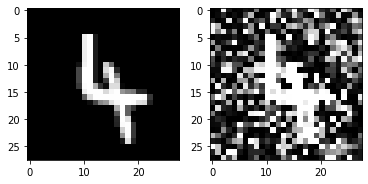

25  :  -0.13996198999470288 25
50  :  0.22846557121529354 25
75  :  0.2146050607098667 25
100  :  0.2917269279047868 25
125  :  0.33769906635193137 25
150  :  0.373494542935584 25
175  :  0.39285797969970043 25
200  :  0.4229063181584639 25
225  :  0.4330371292158323 25
250  :  0.4403582155802445 25
275  :  0.44572812107671556 25
300  :  0.4574817399495475 25
325  :  0.46336050750729885 25
350  :  0.47112793342085013 25
375  :  0.47344347899566347 25
400  :  0.4769705858101132 25
425  :  0.47833641410849453 25
450  :  0.48347174697251993 25
475  :  0.48433916117509557 25
500  :  0.48477795672321083 25
525  :  0.4853126803618222 25
550  :  0.4871533834786578 25
575  :  0.48774048320771507 25
600  :  0.48774048320771507 25
625  :  0.48774048320771507 25
650  :  0.48774048320771507 25
675  :  0.48831188728616276 25
700  :  0.48887741594078726 25
725  :  0.48893896544903354 25
750  :  0.48975914418764593 25
775  :  0.48985151502648533 25
800  :  0.48985151502648533 25
825  :  0.49022123323

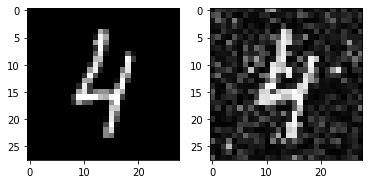

25  :  -0.41073091819556484 25
50  :  -0.41073091819556484 25
75  :  -0.3819792513074234 25
100  :  -0.3412963326144719 25
125  :  -0.31276720578469386 25
150  :  -0.2242481263512827 25
175  :  -0.10046821249488819 25
200  :  -0.03943550801214292 25
225  :  0.05843424270301252 25
250  :  0.11806023953789584 25
275  :  0.12847196190982318 25
300  :  0.18099164601794426 25
325  :  0.20302061595197585 25
350  :  0.2088833481429035 25
375  :  0.22967173565475332 25
400  :  0.2991210856003352 25
425  :  0.34184636643215444 25
450  :  0.3527183864197219 25
475  :  0.3530384802059699 25
500  :  0.3530384802059699 25
525  :  0.3895657140223076 25
550  :  0.3969016937548225 25
575  :  0.41567030473104244 25
600  :  0.41461910419130726 25
625  :  0.41748827073760597 25
650  :  0.41777174435545683 25
675  :  0.4187026818206043 25
700  :  0.4248386131495852 25
725  :  0.4383906066976627 25
750  :  0.44442851627481256 25
775  :  0.4484497464259732 25
800  :  0.45452381249205914 25
825  :  0.4545936

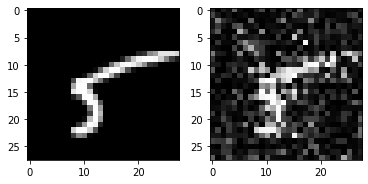

25  :  -0.3578002069854006 25
50  :  -0.3578002069854006 25
75  :  -0.3578002069854006 25
100  :  -0.34438677924889194 25
125  :  -0.2906639785666467 25
150  :  -0.2506541669600116 25
175  :  -0.009935185051259458 25
200  :  0.03843717938449374 25
225  :  0.2606762045003873 25
250  :  0.3008640323687274 25
275  :  0.3506725406018071 25
300  :  0.31573450016323257 25
325  :  0.3507511954502043 25
350  :  0.37262624592266463 25
375  :  0.37260052703925667 25
400  :  0.41323012374063617 25
425  :  0.43279193389299647 25
450  :  0.4656681589943234 25
475  :  0.46446902335081575 25
500  :  0.46446902335081575 25
525  :  0.47101835541301884 25
550  :  0.4723677218030621 25
575  :  0.4827285513580328 25
600  :  0.4827285513580328 25
625  :  0.48385559608215506 25
650  :  0.4858281831772724 25
675  :  0.4858281831772724 25
700  :  0.4858281831772724 25
725  :  0.4859105647801533 25
750  :  0.48851217848447753 25
775  :  0.4900077511628637 25
800  :  0.49011610722135174 25
825  :  0.49011610722

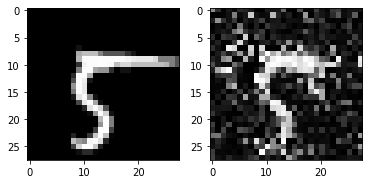

25  :  -0.46905813154561987 25
50  :  -0.46539667547027086 25
75  :  -0.46311319553555047 25
100  :  -0.4565174319196105 25
125  :  -0.4329348157321119 25
150  :  -0.4124638282686623 25
175  :  -0.3489099065731032 25
200  :  -0.28350124468096244 25
225  :  -0.22242315242146252 25
250  :  -0.1739302993070941 25
275  :  -0.13030304604207807 25
300  :  -0.08158114909588812 25
325  :  -0.0638098974122614 25
350  :  -0.0638098974122614 25
375  :  -0.0023881620167466736 25
400  :  0.07417711625267377 25
425  :  0.08984630584428538 25
450  :  0.14787499638732715 25
475  :  0.19978992898556577 25
500  :  0.20476509769961748 25
525  :  0.2723864948197124 25
550  :  0.2974145316691148 25
575  :  0.3011035625924567 25
600  :  0.30837466780233647 25
625  :  0.35217261657648014 25
650  :  0.3501698888034743 25
675  :  0.3708597769002566 25
700  :  0.38844958718051037 25
725  :  0.40370441045791355 25
750  :  0.40506958039188323 25
775  :  0.41323245268569664 25
800  :  0.41832449872344607 25
825  :

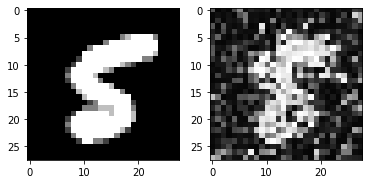

25  :  -0.49297545601277454 25
50  :  -0.4917484589715789 25
75  :  -0.49162648589093166 25
100  :  -0.4888525523086757 25
125  :  -0.479625478446074 25
150  :  -0.4686302616979998 25
175  :  -0.42218238948881787 25
200  :  -0.2664353030931365 25
225  :  -0.0029365521723377537 25
250  :  -0.04491576855968492 25
275  :  -0.02134613142824385 25
300  :  0.0016870738675183088 25
325  :  0.0016870738675183088 25
350  :  0.14326485234069175 25
375  :  0.13971580185216181 25
400  :  0.19216450363866133 25
425  :  0.19133492234691135 25
450  :  0.21685226965397128 25
475  :  0.2188942654833676 25
500  :  0.23505494010299624 25
525  :  0.22625355288732998 25
550  :  0.22684020380710762 25
575  :  0.24038021894456174 25
600  :  0.24039935246351735 25
625  :  0.24258542219634263 25
650  :  0.25220839816577756 25
675  :  0.2562715970839371 25
700  :  0.25745107170957765 25
725  :  0.2679046970672774 25
750  :  0.27627094170382693 25
775  :  0.2779526677121057 25
800  :  0.2825889550518057 25
825  

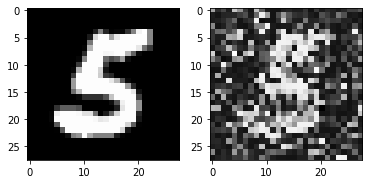

25  :  -0.4886752701430671 25
50  :  -0.4885971400114663 25
75  :  -0.4865302492070635 25
100  :  -0.4853656866437854 25
125  :  -0.4800886833917835 25
150  :  -0.4657255728240374 25
175  :  -0.4455792197543721 25
200  :  -0.43480748603408365 25
225  :  -0.3430398002451659 25
250  :  -0.348183571085862 25
275  :  -0.348183571085862 25
300  :  -0.30054963462262363 25
325  :  -0.30029985747969345 25
350  :  -0.1832344053841218 25
375  :  -0.1253283828533741 25
400  :  -0.13112347408019842 25
425  :  -0.08600109720140958 25
450  :  -0.035490684741259035 25
475  :  -0.03631627256649212 25
500  :  -0.018649886299017458 25
525  :  -0.002684501372314768 25
550  :  0.025237810431502954 25
575  :  0.03240950933093559 25
600  :  0.0413094996644525 25
625  :  0.06098423675074411 25
650  :  0.07072396307313998 25
675  :  0.09169970075842587 25
700  :  0.1032115231851192 25
725  :  0.11693532891083899 25
750  :  0.11761902128937222 25
775  :  0.12694201361365337 25
800  :  0.12694201361365337 25
82

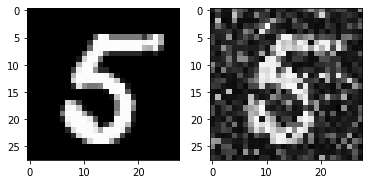

25  :  -0.37113121901055063 25
50  :  -0.326335202921575 25
75  :  -0.3152276344460541 25
100  :  -0.23288186295552235 25
125  :  -0.2357881838849349 25
150  :  -0.13637703161395148 25
175  :  0.03445117167985497 25
200  :  0.10284311989365498 25
225  :  0.16472177448373118 25
250  :  0.3204242881402878 25
275  :  0.38369534722644866 25
300  :  0.39862739599480573 25
325  :  0.4306248228998909 25
350  :  0.4367248274775642 25
375  :  0.4428597282353464 25
400  :  0.4558165270564613 25
425  :  0.4558165270564613 25
450  :  0.4563875304621507 25
475  :  0.460737483818364 25
500  :  0.46234669121442507 25
525  :  0.46278957988910363 25
550  :  0.46699652335745023 25
575  :  0.4680782006265535 25
600  :  0.4682223022052195 25
625  :  0.4699919043652253 25
650  :  0.4731355094020106 25
675  :  0.47547510653825253 25
700  :  0.47661752767189086 25
725  :  0.47963266006182115 25
750  :  0.48041942822939304 25
775  :  0.48067889428743693 25
800  :  0.48209566530385284 25
825  :  0.482301078160

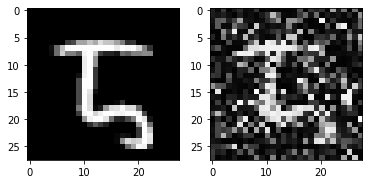

25  :  0.46342886112154996 25
50  :  0.46342886112154996 25
75  :  0.46973225967346177 25
100  :  0.47459091571444284 25
125  :  0.47546606559508314 25
150  :  0.4783826177143018 25
175  :  0.48134945943323576 25
200  :  0.4865364348324773 25
225  :  0.48908970530842594 25
250  :  0.49071112029990493 25
275  :  0.4934638708607952 25
300  :  0.4934984555934209 25
325  :  0.4943392719288756 25
350  :  0.49474982793506417 25
375  :  0.4951569109322823 25
400  :  0.4953694589725745 25
425  :  0.4954514375575672 25
450  :  0.4957591162352532 25
475  :  0.495686776645782 25
500  :  0.495686776645782 25
525  :  0.49595951245725123 25
550  :  0.49595951245725123 25
575  :  0.49595951245725123 25
600  :  0.49595951245725123 25
625  :  0.49595951245725123 25
650  :  0.49595951245725123 25
675  :  0.49595951245725123 25
700  :  0.4960656500045784 25
725  :  0.4961159766643714 25
750  :  0.4961159766643714 25
775  :  0.49616975559856386 25
800  :  0.4963265968160701 25
Time:  78.51876521110535  se

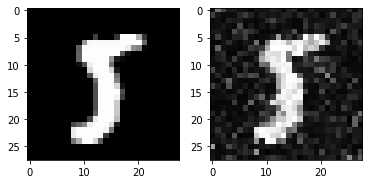

25  :  0.29009203166602743 25
50  :  0.29009203166602743 25
75  :  0.29680790230910287 25
100  :  0.29680790230910287 25
125  :  0.3539159240021643 25
150  :  0.374194695380294 25
175  :  0.3977206728321491 25
200  :  0.40856104348209304 25
225  :  0.43628642953997315 25
250  :  0.46084684184314484 25
275  :  0.4748345923963416 25
300  :  0.4802271060543802 25
325  :  0.4863177425562331 25
350  :  0.4866279573090536 25
375  :  0.4866279573090536 25
400  :  0.4892815370034942 25
425  :  0.48924691384280883 25
450  :  0.4898198276620693 25
475  :  0.4920800969013859 25
500  :  0.49208928736758 25
525  :  0.49265489603958135 25
550  :  0.49265489603958135 25
575  :  0.49265489603958135 25
600  :  0.49265489603958135 25
625  :  0.4935384045598398 25
650  :  0.49402532736158217 25
675  :  0.4942983010066977 25
700  :  0.4945942297118212 25
725  :  0.4949910296220071 25
750  :  0.4952324637006583 25
775  :  0.49530632549595993 25
800  :  0.4954879828142724 25
825  :  0.4956467591079939 25
85

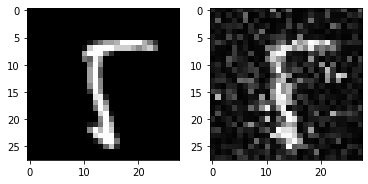

25  :  -0.17534591308790537 25
50  :  -0.15865727021605217 25
75  :  -0.11697392963609221 25
100  :  -0.0076440644909665355 25
125  :  0.12486233868567194 25
150  :  0.3093016194177437 25
175  :  0.31680239683129635 25
200  :  0.4462927439934085 25
225  :  0.4549392205911081 25
250  :  0.47540654047184056 25
275  :  0.4763215184059886 25
300  :  0.4773799606242342 25
325  :  0.4847991797432274 25
350  :  0.4847991797432274 25
375  :  0.4869884814333992 25
400  :  0.48891584538979327 25
425  :  0.49098580681728116 25
450  :  0.49143637417312347 25
475  :  0.4924593015919397 25
500  :  0.49187196712533504 25
525  :  0.49387428656998167 25
550  :  0.4937961962689929 25
575  :  0.494027713930894 25
600  :  0.49409691089337254 25
625  :  0.494209583140735 25
650  :  0.49439527161432617 25
675  :  0.49439844353490175 25
700  :  0.4944721168615633 25
725  :  0.4946055246116273 25
750  :  0.49461271957847797 25
775  :  0.4947829319726107 25
800  :  0.4947861376386714 25
825  :  0.4948017346506

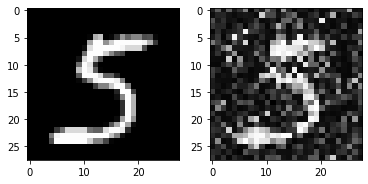

25  :  -0.0880976058725485 25
50  :  -0.0880976058725485 25
75  :  -0.07768416299592217 25
100  :  -0.053715085565889234 25
125  :  0.0087682652014073 25
150  :  0.06595447799816136 25
175  :  0.1663243863592662 25
200  :  0.18732902984263528 25
225  :  0.25658252814744303 25
250  :  0.32913670774224746 25
275  :  0.3371785350933167 25
300  :  0.35113453954638457 25
325  :  0.370569072542668 25
350  :  0.37993132788489514 25
375  :  0.3950285414780081 25
400  :  0.39084581401220697 25
425  :  0.39846448843372057 25
450  :  0.40727257191906435 25
475  :  0.4182285022499222 25
500  :  0.42400954769583893 25
525  :  0.43808016403361727 25
550  :  0.4377110330865734 25
575  :  0.45423395169146474 25
600  :  0.4531906937959377 25
625  :  0.45348529904950247 25
650  :  0.4556184588237571 25
675  :  0.4627346683706444 25
700  :  0.4636585671561556 25
725  :  0.46688227661667536 25
750  :  0.4674162758120609 25
775  :  0.470058544795081 25
800  :  0.46996032276798494 25
825  :  0.4701807194496

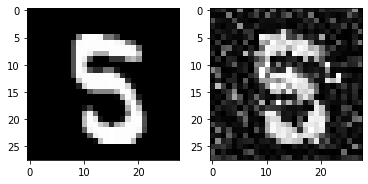

25  :  0.2251363281329989 25
50  :  0.24132899129770244 25
75  :  0.27059219611240215 25
100  :  0.33816981118274747 25
125  :  0.3647106525771144 25
150  :  0.40099481331372294 25
175  :  0.4150944757982758 25
200  :  0.4419088588269649 25
225  :  0.4652337391153247 25
250  :  0.4809572271298843 25
275  :  0.4875301805824804 25
300  :  0.48889877228398027 25
325  :  0.4891404243836872 25
350  :  0.4891404243836872 25
375  :  0.49206154523726736 25
400  :  0.4925003740756676 25
425  :  0.4925003740756676 25
450  :  0.4925244624692288 25
475  :  0.49280400563242027 25
500  :  0.49364788529939624 25
525  :  0.4948880645177154 25
550  :  0.4948879431291478 25
575  :  0.4948879431291478 25
600  :  0.49498420425043 25
625  :  0.4950497434308272 25
650  :  0.49516340936438596 25
675  :  0.4952224362740179 25
700  :  0.4953046992991958 25
725  :  0.4953626728708859 25
750  :  0.4954646318636814 25
775  :  0.4954876167462248 25
800  :  0.4955343755705153 25
825  :  0.4955603802129377 25
850  :

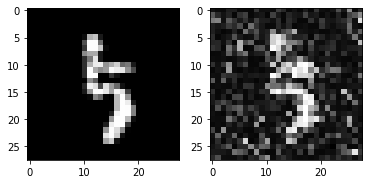

25  :  -0.4029134712728332 25
50  :  -0.4029134712728332 25
75  :  -0.39288936969382693 25
100  :  -0.3819708350304353 25
125  :  -0.3721622530191324 25
150  :  -0.28037588046783457 25
175  :  -0.2527137486533606 25
200  :  -0.21014031425600127 25
225  :  -0.09733403648190925 25
250  :  0.12429529054583946 25
275  :  0.15103054656424644 25
300  :  0.18877314146238888 25
325  :  0.2708899212889667 25
350  :  0.28586212577667147 25
375  :  0.32345100974641366 25
400  :  0.32345100974641366 25
425  :  0.3778239178248336 25
450  :  0.3855767383312755 25
475  :  0.3946043537652977 25
500  :  0.42504125837856677 25
525  :  0.43551676027303643 25
550  :  0.4451853035980529 25
575  :  0.44715178430495534 25
600  :  0.4524206816199192 25
625  :  0.458179810737902 25
650  :  0.45862290274697104 25
675  :  0.4651658239384401 25
700  :  0.4716993887357774 25
725  :  0.47218821388075605 25
750  :  0.47387419890395355 25
775  :  0.4766678085940974 25
800  :  0.47749248583060894 25
825  :  0.47715222

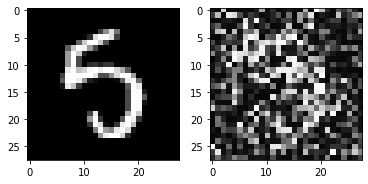

25  :  0.40086629280591224 25
50  :  0.455417900675064 25
75  :  0.4356263821371181 25
100  :  0.4406310391732681 25
125  :  0.44540577294876477 25
150  :  0.45974326058087484 25
175  :  0.45803375039090727 25
200  :  0.45803375039090727 25
225  :  0.4622545520433138 25
250  :  0.4651598218167383 25
275  :  0.47123470763900677 25
300  :  0.47795439095189607 25
325  :  0.47841901011008114 25
350  :  0.4787038797105286 25
375  :  0.48060407137755795 25
400  :  0.4804476881112929 25
425  :  0.4804476881112929 25
450  :  0.4804476881112929 25
475  :  0.48220892298549956 25
500  :  0.48347447679729116 25
525  :  0.4842956863106516 25
550  :  0.48554121060531674 25
575  :  0.4861044011938965 25
600  :  0.48833594965906607 25
625  :  0.4889101757287895 25
650  :  0.4896300349689027 25
675  :  0.49007705124989787 25
700  :  0.4904291626291044 25
725  :  0.4911555390213659 25
750  :  0.4911455960670522 25
775  :  0.49147743097999497 25
800  :  0.4914515284540555 25
825  :  0.4915524266973928 25

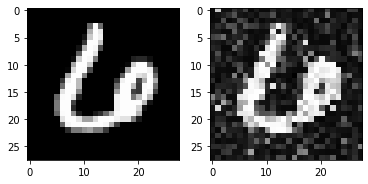

25  :  0.2274084680883855 25
50  :  0.4229728352530329 25
75  :  0.38844280263492714 25
100  :  0.4333766695526598 25
125  :  0.4619972268363822 25
150  :  0.4713199242812445 25
175  :  0.4774368249321125 25
200  :  0.4789386185240334 25
225  :  0.4835194688169945 25
250  :  0.48478468211133463 25
275  :  0.4835413917865038 25
300  :  0.4831727787230386 25
325  :  0.48488237954868935 25
350  :  0.4842347889926802 25
375  :  0.486830814041561 25
400  :  0.4862709013756111 25
425  :  0.48726764672791995 25
450  :  0.48817695946554407 25
475  :  0.48812143966516586 25
500  :  0.48867755744488417 25
525  :  0.489404907573904 25
550  :  0.4894386728481168 25
575  :  0.48947943007343736 25
600  :  0.490132321292531 25
625  :  0.49022694154833707 25
650  :  0.4903162836614389 25
675  :  0.4903162836614389 25
700  :  0.4903279038657872 25
725  :  0.4903279038657872 25
750  :  0.49047815732738886 25
775  :  0.4904848867433829 25
800  :  0.49060149313419804 25
825  :  0.4907306198327642 25
850  

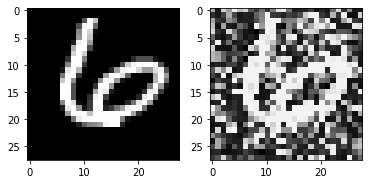

25  :  0.33107112961755647 25
50  :  0.48848380610912995 25
75  :  0.44556180770455844 25
100  :  0.47119347907155457 25
125  :  0.48852963815903433 25
150  :  0.48863615222466844 25
175  :  0.48956295239027153 25
200  :  0.49057063152997377 25
225  :  0.49076798737333027 25
250  :  0.4909609664619445 25
275  :  0.4909836439598061 25
300  :  0.4913437998199615 25
325  :  0.4916656748290736 25
350  :  0.49189617476084646 25
375  :  0.4919722685841389 25
400  :  0.49216708914625396 25
425  :  0.492113764203522 25
450  :  0.49226805129236734 25
475  :  0.49239096454540665 25
500  :  0.4924107374515699 25
525  :  0.49249817585323247 25
550  :  0.4927472238407069 25
575  :  0.4927907767300137 25
600  :  0.4928851401047812 25
625  :  0.4929661027995451 25
650  :  0.49296163288455375 25
675  :  0.4929868490487605 25
700  :  0.49301808622939086 25
725  :  0.4930540811122845 25
750  :  0.4930540811122845 25
775  :  0.4930812741775331 25
800  :  0.4931809976714 25
825  :  0.49318047006976584 25


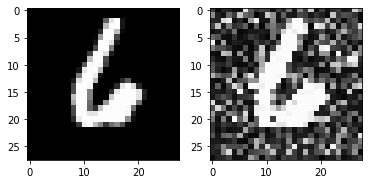

25  :  0.2653153793396311 25
50  :  0.4842792711739179 25
75  :  0.48523223117928166 25
100  :  0.4873148973050625 25
125  :  0.4897225519487718 25
150  :  0.48981463295239436 25
175  :  0.4887796323603333 25
200  :  0.48943658518983724 25
225  :  0.4908904852075631 25
250  :  0.49009719771004756 25
275  :  0.49008554139019855 25
300  :  0.49059299459186373 25
325  :  0.4907915202429606 25
350  :  0.49093090367430303 25
375  :  0.49114103769219875 25
400  :  0.49143040341763883 25
425  :  0.49143040341763883 25
450  :  0.4914805170824913 25
475  :  0.491456575141089 25
500  :  0.4918203517307352 25
525  :  0.49208452871940317 25
550  :  0.4920893191860153 25
575  :  0.4921470595602061 25
600  :  0.49218138214394375 25
625  :  0.49229064376077214 25
650  :  0.4924111870523171 25
675  :  0.49242994905392895 25
700  :  0.49242994905392895 25
725  :  0.49242994905392895 25
750  :  0.4924374939811706 25
775  :  0.4924579101867529 25
800  :  0.4924884432410803 25
825  :  0.49252772403361894 

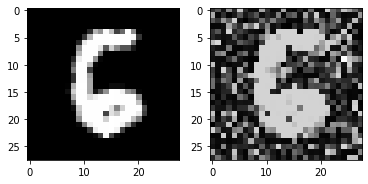

25  :  0.016988464880565934 25
50  :  0.4806098312118753 25
75  :  0.4311186728189187 25
100  :  0.4402499103735249 25
125  :  0.47591000091305424 25
150  :  0.4768336865360966 25
175  :  0.47784807258611794 25
200  :  0.4835721038496401 25
225  :  0.48543569270685816 25
250  :  0.48522629051900995 25
275  :  0.48692841918533564 25
300  :  0.48733204663742385 25
325  :  0.48733157634702634 25
350  :  0.4881463472577276 25
375  :  0.4895413648843315 25
400  :  0.4894854483279157 25
425  :  0.4900415884991391 25
450  :  0.4900573278290389 25
475  :  0.4903480680582054 25
500  :  0.4903758938186835 25
525  :  0.49055442019047735 25
550  :  0.49073087294679024 25
575  :  0.49073600022910424 25
600  :  0.49083330968850636 25
625  :  0.4909288114229703 25
650  :  0.491113727619927 25
675  :  0.491366007089668 25
700  :  0.491366007089668 25
725  :  0.4913707136330901 25
750  :  0.49139718331008425 25
775  :  0.4914331208157998 25
800  :  0.4914648331462145 25
825  :  0.49153241472891557 25
8

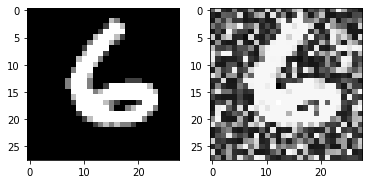

25  :  0.16583719836638894 25
50  :  0.47882431534507097 25
75  :  0.4647353321543412 25
100  :  0.464603602902019 25
125  :  0.4801532139787098 25
150  :  0.4816695088653466 25
175  :  0.4826147680913083 25
200  :  0.4823353314423311 25
225  :  0.48452619459457635 25
250  :  0.48514263565279125 25
275  :  0.4849595162000809 25
300  :  0.4858948658161776 25
325  :  0.4858352964168558 25
350  :  0.4859003395877618 25
375  :  0.48713280729970954 25
400  :  0.4868869168560576 25
425  :  0.4877112733486221 25
450  :  0.48791347409538677 25
475  :  0.4881444601415064 25
500  :  0.4884933734850368 25
525  :  0.4884933734850368 25
550  :  0.48896227444657187 25
575  :  0.48899910900751514 25
600  :  0.48898220124379405 25
625  :  0.4891646429330383 25
650  :  0.4891646429330383 25
675  :  0.4892864212617843 25
700  :  0.48950608183490935 25
725  :  0.48966792806660225 25
750  :  0.4896816623681968 25
775  :  0.48983272378462106 25
800  :  0.4898632734861219 25
825  :  0.4900020200073489 25
85

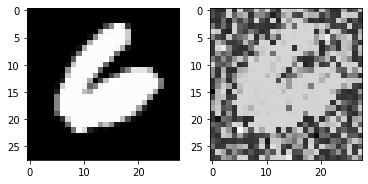

25  :  0.4901870108519546 25
50  :  0.4905856084558158 25
75  :  0.49183349549393157 25
100  :  0.4920947869516463 25
125  :  0.49204016667787615 25
150  :  0.49256707287182283 25
175  :  0.4927115466999575 25
200  :  0.49280892779938534 25
225  :  0.49277919352473865 25
250  :  0.49326690549271923 25
275  :  0.4932145088229196 25
300  :  0.49373593051697684 25
325  :  0.49382141341421226 25
350  :  0.49399205425498116 25
375  :  0.4940015636538172 25
400  :  0.49417295311765036 25
425  :  0.4942264355063359 25
450  :  0.4942962976741174 25
475  :  0.4943734047972791 25
500  :  0.4943907634677521 25
525  :  0.4945006192419627 25
550  :  0.49453846676133917 25
575  :  0.4945761810720654 25
600  :  0.4946059840860397 25
625  :  0.4946059840860397 25
650  :  0.4946059840860397 25
675  :  0.4946156528657005 25
700  :  0.4946156528657005 25
725  :  0.49462125743415863 25
750  :  0.494637514777032 25
775  :  0.4946600854392872 25
800  :  0.49466429211144386 25
Time:  85.89310765266418  secon

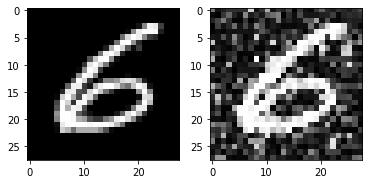

25  :  0.45436838665901425 25
50  :  0.486436180135907 25
75  :  0.4715950216561104 25
100  :  0.4856841394418689 25
125  :  0.48479354619779375 25
150  :  0.48658419833362926 25
175  :  0.48689741739636627 25
200  :  0.48641009981443106 25
225  :  0.4855207158260905 25
250  :  0.4840030744349658 25
275  :  0.48486544114382873 25
300  :  0.48752246542594385 25
325  :  0.4879436119755635 25
350  :  0.4891603207955339 25
375  :  0.4903103157934313 25
400  :  0.4896653663889822 25
425  :  0.49014159874369884 25
450  :  0.4899945272079023 25
475  :  0.49027622423070166 25
500  :  0.4908548605818685 25
525  :  0.4908548605818685 25
550  :  0.49125848494252744 25
575  :  0.491241969121496 25
600  :  0.4915579625297997 25
625  :  0.4915579625297997 25
650  :  0.49160407837224884 25
675  :  0.49171242536712756 25
700  :  0.49176425247543437 25
725  :  0.49182815320978496 25
750  :  0.4918613598108334 25
775  :  0.49188586005866525 25
800  :  0.49191700654069404 25
825  :  0.49192993945524105 2

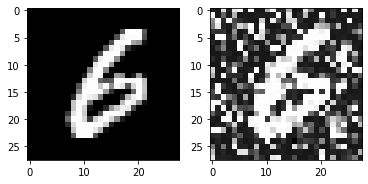

25  :  -0.39344961006891827 25
50  :  0.43009145836596124 25
75  :  0.21537050064566116 25
100  :  0.3925362894077167 25
125  :  0.4502853799229685 25
150  :  0.46847722895981486 25
175  :  0.4753975364660864 25
200  :  0.47883394781949395 25
225  :  0.4809962821778569 25
250  :  0.48132912401741035 25
275  :  0.4812280216529732 25
300  :  0.48403725852664053 25
325  :  0.4853055116800367 25
350  :  0.4859323713055245 25
375  :  0.48699488121717893 25
400  :  0.48667213901127465 25
425  :  0.48774528319293287 25
450  :  0.48831413884545255 25
475  :  0.48877861516114274 25
500  :  0.4892393959756931 25
525  :  0.4893053561064864 25
550  :  0.4893465361458751 25
575  :  0.4896140103526741 25
600  :  0.4896210003368934 25
625  :  0.48969822945482905 25
650  :  0.48974669494801215 25
675  :  0.48973497627744034 25
700  :  0.4897630886529193 25
725  :  0.48992525793983815 25
750  :  0.4899502782063597 25
775  :  0.4900040583686488 25
800  :  0.4900040583686488 25
825  :  0.4901293030107509

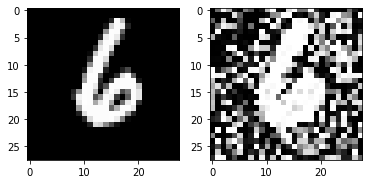

25  :  0.4702792969258543 25
50  :  0.49106672341434154 25
75  :  0.4909983712695252 25
100  :  0.48975576403542764 25
125  :  0.49048419015919337 25
150  :  0.49062469366597167 25
175  :  0.4912444144074164 25
200  :  0.491102381460574 25
225  :  0.4915188583166693 25
250  :  0.4917359796536944 25
275  :  0.4920322852797145 25
300  :  0.49197287449139954 25
325  :  0.4922014071094231 25
350  :  0.49206239838505406 25
375  :  0.4922426038140586 25
400  :  0.49233716378053305 25
425  :  0.4923689901256869 25
450  :  0.4925041240052184 25
475  :  0.4927678283937279 25
500  :  0.4927678283937279 25
525  :  0.49279402716319887 25
550  :  0.49293012656326135 25
575  :  0.49293955531926725 25
600  :  0.4929949660887868 25
625  :  0.4931760508954936 25
650  :  0.4932438885397691 25
675  :  0.4932575611259094 25
700  :  0.4933216585729266 25
725  :  0.49336556835853435 25
750  :  0.49338471335456574 25
775  :  0.49339627135281 25
800  :  0.49340808682236326 25
825  :  0.4934901118016905 25
Tim

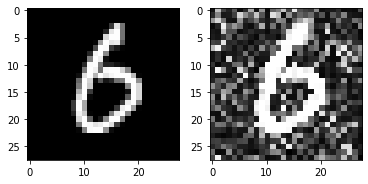

25  :  0.09427757501416142 25
50  :  0.4709924487456095 25
75  :  0.33711166588320257 25
100  :  0.4599369131134507 25
125  :  0.4766282128488374 25
150  :  0.4842759736223393 25
175  :  0.48628765409371316 25
200  :  0.4876282839525843 25
225  :  0.4868936836287807 25
250  :  0.4883108479700103 25
275  :  0.4882694140922774 25
300  :  0.4885548136236606 25
325  :  0.4890204754898839 25
350  :  0.488964201194024 25
375  :  0.48961707323332654 25
400  :  0.4899672273007223 25
425  :  0.4900816188715315 25
450  :  0.4904026283280406 25
475  :  0.4907553710251763 25
500  :  0.49086060960745154 25
525  :  0.49088375880734036 25
550  :  0.4912749478762569 25
575  :  0.49130883711868556 25
600  :  0.49139831276686435 25
625  :  0.4916630000735526 25
650  :  0.49166968247693676 25
675  :  0.4917726095276995 25
700  :  0.4918094357478223 25
725  :  0.49184498196914334 25
750  :  0.4918847351315693 25
775  :  0.4919148545756565 25
800  :  0.49191466516841553 25
825  :  0.49192657788456273 25
85

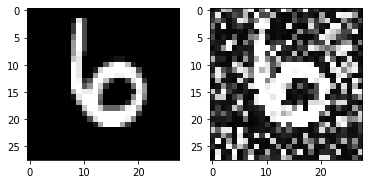

25  :  0.22729520585405713 25
50  :  0.45452762057769214 25
75  :  0.41368838690821774 25
100  :  0.4740865178469317 25
125  :  0.4825547151649776 25
150  :  0.48418706230468134 25
175  :  0.48432127446638384 25
200  :  0.4846069702018806 25
225  :  0.48582956487457335 25
250  :  0.4873488444065202 25
275  :  0.4859007862633283 25
300  :  0.48761952939809433 25
325  :  0.4884209467321785 25
350  :  0.49010011777078355 25
375  :  0.4900997721192908 25
400  :  0.4899640394185336 25
425  :  0.4902919611077745 25
450  :  0.49125394976055586 25
475  :  0.49110549350753857 25
500  :  0.49125703558064016 25
525  :  0.49182405136900276 25
550  :  0.49182405136900276 25
575  :  0.4919672359230065 25
600  :  0.4920652937948647 25
625  :  0.4921544900195822 25
650  :  0.49221530953348835 25
675  :  0.49221530953348835 25
700  :  0.4922356537493134 25
725  :  0.492334931104463 25
750  :  0.49234042177418386 25
775  :  0.4923509670640185 25
800  :  0.4923529335116876 25
825  :  0.49244666259736847 

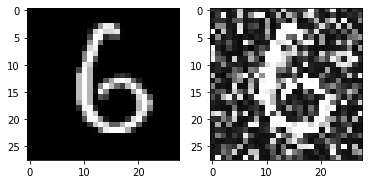

25  :  0.44596965782844056 25
50  :  0.48679610210864455 25
75  :  0.45893734595145824 25
100  :  0.47103276611216577 25
125  :  0.4684089703038962 25
150  :  0.47345850388896016 25
175  :  0.4659470548606139 25
200  :  0.4658306679998497 25
225  :  0.46467226789777905 25
250  :  0.43251780942418316 25
275  :  0.45384903329204784 25
300  :  0.45832881400779585 25
325  :  0.4716656935829634 25
350  :  0.47639261130025057 25
375  :  0.48021627387526733 25
400  :  0.48326762257782685 25
425  :  0.48326762257782685 25
450  :  0.48326762257782685 25
475  :  0.48326762257782685 25
500  :  0.48343676531520535 25
525  :  0.4861703834570664 25
550  :  0.486678756617381 25
575  :  0.48825800173734435 25
600  :  0.48974851007396825 25
625  :  0.4908416134457985 25
650  :  0.4914121473658755 25
675  :  0.4916456941043445 25
700  :  0.49225936003774917 25
725  :  0.49235097241447595 25
750  :  0.4924798214493978 25
775  :  0.4926912690769817 25
800  :  0.4929865819674466 25
825  :  0.49298234177162

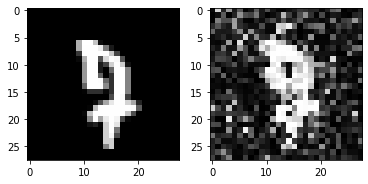

25  :  0.37283691234063177 25
50  :  0.45564262407521555 25
75  :  0.4214981809894777 25
100  :  0.4247717168283302 25
125  :  0.4586865460462429 25
150  :  0.45980535461643374 25
175  :  0.4263908456384087 25
200  :  0.403977980075414 25
225  :  0.41311461695194107 25
250  :  0.41120570500417625 25
275  :  0.42167644197133514 25
300  :  0.4314882211731254 25
325  :  0.43401211119032507 25
350  :  0.4502530953062745 25
375  :  0.44601807087228396 25
400  :  0.44601807087228396 25
425  :  0.4464435645447705 25
450  :  0.4511667188173131 25
475  :  0.45885202131461167 25
500  :  0.45885202131461167 25
525  :  0.46203622319567483 25
550  :  0.4639802474673548 25
575  :  0.46642853924742506 25
600  :  0.4671477390225076 25
625  :  0.4710768935457514 25
650  :  0.4744719348457531 25
675  :  0.474306666429716 25
700  :  0.4755808031511004 25
725  :  0.47844754124982436 25
750  :  0.4779840674362471 25
775  :  0.4786223638709944 25
800  :  0.47970439991251196 25
825  :  0.4814545044810949 25


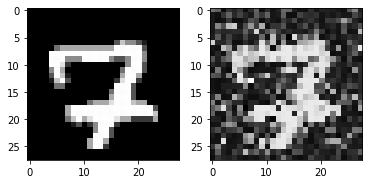

25  :  -0.2285593669303451 25
50  :  0.4530037719504887 25
75  :  0.16152543259555088 25
100  :  0.35059752272367367 25
125  :  0.35780556131475344 25
150  :  0.47168146178942494 25
175  :  0.4716348991600932 25
200  :  0.4790348401969119 25
225  :  0.48232973661946155 25
250  :  0.4832669563674471 25
275  :  0.4850315102854644 25
300  :  0.4865491426713622 25
325  :  0.488236527246587 25
350  :  0.4884025873200025 25
375  :  0.4891612676314925 25
400  :  0.4890525531507146 25
425  :  0.48946689673453303 25
450  :  0.4896216188203548 25
475  :  0.48953878272077955 25
500  :  0.48993254501386957 25
525  :  0.489962587880041 25
550  :  0.4902486178845779 25
575  :  0.4903693627264498 25
600  :  0.4904020911845596 25
625  :  0.4907063361522612 25
650  :  0.49076986499221115 25
675  :  0.49097271180784263 25
700  :  0.4909720529430118 25
725  :  0.4909720529430118 25
750  :  0.4910030712503704 25
775  :  0.4910850960219058 25
800  :  0.491148920459379 25
825  :  0.49120248503261343 25
850 

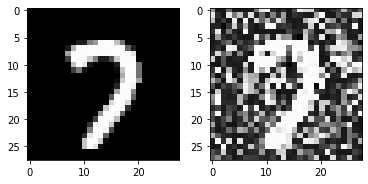

25  :  -0.4600661213740253 25
50  :  0.2502675454428365 25
75  :  0.08895910910348757 25
100  :  0.3978287828042243 25
125  :  0.42162330350483246 25
150  :  0.4812997764166062 25
175  :  0.48392588986381324 25
200  :  0.4855273301567076 25
225  :  0.485651234903951 25
250  :  0.48574571464035254 25
275  :  0.4864362806037243 25
300  :  0.48882766655274745 25
325  :  0.4873005609910558 25
350  :  0.4891659763671874 25
375  :  0.48804018952629685 25
400  :  0.48957371297784197 25
425  :  0.4894190833451994 25
450  :  0.4895461442367889 25
475  :  0.4899851778113691 25
500  :  0.4903158435878175 25
525  :  0.49029454945100764 25
550  :  0.49058698126078043 25
575  :  0.49064120505809794 25
600  :  0.49093231211253 25
625  :  0.4909830436967873 25
650  :  0.49097345895243333 25
675  :  0.4914608665705801 25
700  :  0.49144167968282954 25
725  :  0.4915360050124936 25
750  :  0.4915250240731164 25
775  :  0.4915865753607346 25
800  :  0.4916295454086357 25
825  :  0.4916709008069624 25
850

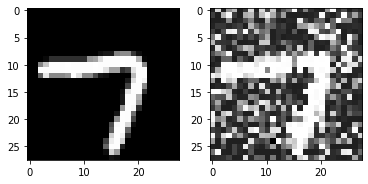

25  :  -0.41188234650504996 25
50  :  0.4314358762179281 25
75  :  0.17205219643857564 25
100  :  0.4018011590122464 25
125  :  0.43531566454425624 25
150  :  0.46914640345850733 25
175  :  0.4785270181149204 25
200  :  0.4811327253043463 25
225  :  0.4826368247673577 25
250  :  0.48394144778700654 25
275  :  0.48333228031290754 25
300  :  0.4832297298887225 25
325  :  0.48315415799948314 25
350  :  0.4837750902723994 25
375  :  0.4844507572204909 25
400  :  0.48558257919212783 25
425  :  0.48594480204409046 25
450  :  0.48595719173419866 25
475  :  0.4868441013260129 25
500  :  0.48736698788052113 25
525  :  0.4877123241840682 25
550  :  0.4881149080270599 25
575  :  0.48799883255380705 25
600  :  0.48829637337251747 25
625  :  0.48851302630706556 25
650  :  0.48864645005787205 25
675  :  0.4887643754618538 25
700  :  0.48920478798586237 25
725  :  0.48927787065461653 25
750  :  0.4892975986489622 25
775  :  0.48939970248317 25
800  :  0.4896515962084873 25
825  :  0.48961440643547266

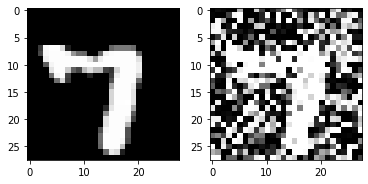

25  :  0.308583350685436 25
50  :  0.35813352754883176 25
75  :  0.3577905790005986 25
100  :  0.38633431320818945 25
125  :  0.37839819746917286 25
150  :  0.430047574811361 25
175  :  0.3965719442770669 25
200  :  0.4312030055651935 25
225  :  0.40378183913270815 25
250  :  0.4179062041353069 25
275  :  0.4366199577156017 25
300  :  0.44773686523419776 25
325  :  0.4266109610005964 25
350  :  0.44088401078905204 25
375  :  0.4374499432297578 25
400  :  0.45871742655410014 25
425  :  0.4427626832344616 25
450  :  0.4546447017929215 25
475  :  0.44537810272917516 25
500  :  0.4551126293336302 25
525  :  0.463422436202646 25
550  :  0.47671890525311633 25
575  :  0.47495151078169645 25
600  :  0.47495151078169645 25
625  :  0.47895244142539245 25
650  :  0.4765564323202501 25
675  :  0.47758603846222253 25
700  :  0.4828863207406767 25
725  :  0.4828684041179494 25
750  :  0.48726091243758757 25
775  :  0.48723217721925927 25
800  :  0.488308301383632 25
825  :  0.48974165277393505 25
8

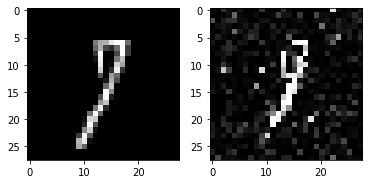

25  :  0.24295574652520885 25
50  :  0.3765630649856651 25
75  :  0.4005371985289092 25
100  :  0.40906038228178293 25
125  :  0.42540065255471116 25
150  :  0.435159035013591 25
175  :  0.4669635996420622 25
200  :  0.4784117889656915 25
225  :  0.4820199374310762 25
250  :  0.48960695719718095 25
275  :  0.490476579755375 25
300  :  0.490476579755375 25
325  :  0.49174452925435086 25
350  :  0.49165626778995236 25
375  :  0.49172843766369223 25
400  :  0.4921782502912502 25
425  :  0.49242538546019515 25
450  :  0.4928114236772412 25
475  :  0.49293100935619855 25
500  :  0.49302500190809595 25
525  :  0.49336622369597216 25
550  :  0.4936473844392434 25
575  :  0.4936441776936441 25
600  :  0.4936441776936441 25
625  :  0.49392367065458603 25
650  :  0.49392367065458603 25
675  :  0.49399467432003 25
700  :  0.49415734131697897 25
725  :  0.4943215029660768 25
750  :  0.494361280312136 25
775  :  0.49438943878740205 25
800  :  0.49452839612184746 25
825  :  0.49452738565723436 25
85

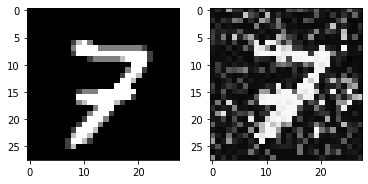

25  :  0.026165533750966412 25
50  :  0.4056134867130353 25
75  :  0.2653501061538474 25
100  :  0.3735560742551061 25
125  :  0.46476142549274974 25
150  :  0.4849596321664467 25
175  :  0.48709181690263553 25
200  :  0.48909841986861763 25
225  :  0.48870462453142466 25
250  :  0.4894429514128181 25
275  :  0.48942801754576004 25
300  :  0.49034499674547904 25
325  :  0.4902578891384232 25
350  :  0.4903722220946436 25
375  :  0.4906034552205731 25
400  :  0.49072396749938757 25
425  :  0.4908808374654044 25
450  :  0.49128661772931026 25
475  :  0.49128661772931026 25
500  :  0.49145144932681184 25
525  :  0.491464021062508 25
550  :  0.4914906119783745 25
575  :  0.49155867663504654 25
600  :  0.49157340901790125 25
625  :  0.4916316022600485 25
650  :  0.4916621772338396 25
675  :  0.49180051190214347 25
700  :  0.49180297088762853 25
725  :  0.49180297088762853 25
750  :  0.4918904680926539 25
775  :  0.49197657317089183 25
800  :  0.4919996594262764 25
825  :  0.4920729033927550

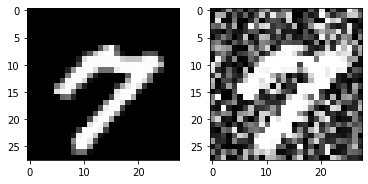

25  :  -0.4868419561557157 25
50  :  -0.3036621431387764 25
75  :  -0.293154732395435 25
100  :  -0.18810322205755203 25
125  :  -0.0005843846084218028 25
150  :  0.42060463590467867 25
175  :  0.45617224534824413 25
200  :  0.48296136318049104 25
225  :  0.48373858277917914 25
250  :  0.48552866077799084 25
275  :  0.4858234618888492 25
300  :  0.4863226422271935 25
325  :  0.48592529031648846 25
350  :  0.4860764242244706 25
375  :  0.4866205137778423 25
400  :  0.48660572157448584 25
425  :  0.48693246551803804 25
450  :  0.48801294631202274 25
475  :  0.48796462791096756 25
500  :  0.48796462791096756 25
525  :  0.48824115450992983 25
550  :  0.4884178115866013 25
575  :  0.48850044320936953 25
600  :  0.4885912370046427 25
625  :  0.4887926408698985 25
650  :  0.4890888296012818 25
675  :  0.4891392894910388 25
700  :  0.4891818964274878 25
725  :  0.4891818964274878 25
750  :  0.4893731191717302 25
775  :  0.4893621015992831 25
800  :  0.48946115032820714 25
825  :  0.48954686177

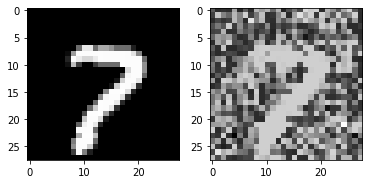

25  :  -0.44396560415091285 25
50  :  -0.050799957892199356 25
75  :  -0.3802792257372989 25
100  :  -0.24330395286086054 25
125  :  0.13734437784049863 25
150  :  0.41039719544017056 25
175  :  0.4589900956306622 25
200  :  0.4795501843747551 25
225  :  0.48307208496783316 25
250  :  0.4841175769461157 25
275  :  0.4840251910186641 25
300  :  0.48242466260582106 25
325  :  0.48221727812580994 25
350  :  0.4839631949225455 25
375  :  0.4843858909889997 25
400  :  0.4845615915510785 25
425  :  0.4847326842365849 25
450  :  0.48510616787049926 25
475  :  0.48500935096828446 25
500  :  0.4851915250436711 25
525  :  0.48550241765326924 25
550  :  0.48557732928690606 25
575  :  0.4861139600884055 25
600  :  0.48620322871132915 25
625  :  0.48614683137111553 25
650  :  0.48627241661795895 25
675  :  0.4866035190388145 25
700  :  0.48663651875283215 25
725  :  0.4868893985164358 25
750  :  0.4868420823485551 25
775  :  0.4871267569156837 25
800  :  0.4872519405102895 25
825  :  0.487646416675

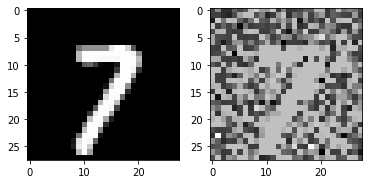

25  :  -0.36288685916112984 25
50  :  -0.059397946869507945 25
75  :  0.1276492094960468 25
100  :  0.3081785405638588 25
125  :  0.4466190809720177 25
150  :  0.4818065860443397 25
175  :  0.4900139436869914 25
200  :  0.4910846068115176 25
225  :  0.4910846068115176 25
250  :  0.4910846068115176 25
275  :  0.49224507234174586 25
300  :  0.4922646362293058 25
325  :  0.4932706818960832 25
350  :  0.493429585900622 25
375  :  0.49348654126186897 25
400  :  0.49350251739648493 25
425  :  0.4938199226405717 25
450  :  0.4939779424901651 25
475  :  0.4941071024459428 25
500  :  0.49409663262905507 25
525  :  0.49417998253631557 25
550  :  0.49417049970090676 25
575  :  0.49428336708081205 25
600  :  0.4944561515554658 25
625  :  0.49448287372812016 25
650  :  0.49449208193669747 25
675  :  0.49464304128188474 25
700  :  0.49470499814839547 25
725  :  0.494732482238193 25
750  :  0.49473256442507746 25
775  :  0.4947528643275036 25
800  :  0.49484339920123516 25
825  :  0.49484573096226214

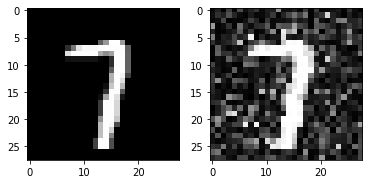

25  :  -0.4851932394679274 25
50  :  -0.32181089951016967 25
75  :  -0.3855865872608176 25
100  :  -0.13491501517112875 25
125  :  0.10706005580304777 25
150  :  0.43907391920578304 25
175  :  0.4518544226428692 25
200  :  0.4619096278043704 25
225  :  0.46434412941105957 25
250  :  0.4637190266122305 25
275  :  0.46451005525060696 25
300  :  0.4677331279025369 25
325  :  0.4677331279025369 25
350  :  0.4743146606596158 25
375  :  0.47661353163495257 25
400  :  0.4843358661231194 25
425  :  0.4844516480565427 25
450  :  0.4857973063907532 25
475  :  0.48577674252888936 25
500  :  0.48577674252888936 25
525  :  0.48578593992889696 25
550  :  0.48577674252888936 25
575  :  0.4859121100689112 25
600  :  0.4880702649249647 25
625  :  0.48831852966789213 25
650  :  0.4885811279573716 25
675  :  0.4895046512265633 25
700  :  0.4901524111253397 25
725  :  0.4902070306572609 25
750  :  0.49065668976871085 25
775  :  0.49178634448992087 25
800  :  0.49181688111657174 25
825  :  0.49212188154289

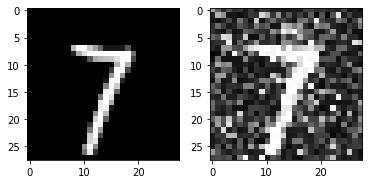

25  :  -0.2829396850874171 25
50  :  0.03089456156717986 25
75  :  0.04652405598193776 25
100  :  0.3352889137357797 25
125  :  0.4504033398149699 25
150  :  0.4694977485257911 25
175  :  0.48182295406416875 25
200  :  0.4829899197813778 25
225  :  0.4829899197813778 25
250  :  0.48406896478397077 25
275  :  0.48610287471683966 25
300  :  0.48610287471683966 25
325  :  0.4862454646147189 25
350  :  0.48734731093308953 25
375  :  0.4886916392786322 25
400  :  0.4888864420583179 25
425  :  0.4888758704175698 25
450  :  0.48931756252447334 25
475  :  0.4895562054071571 25
500  :  0.4904273536331266 25
525  :  0.490618464196521 25
550  :  0.49102324464012004 25
575  :  0.4912572413789229 25
600  :  0.4918214992976677 25
625  :  0.4919936578392129 25
650  :  0.49204411345908 25
675  :  0.49233153329935564 25
700  :  0.4925139309259462 25
725  :  0.49277060512515874 25
750  :  0.49278924741591246 25
775  :  0.49286762948523677 25
800  :  0.49309253897565947 25
825  :  0.49326875786327296 25


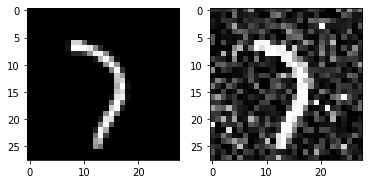

25  :  -0.21997745043215516 25
50  :  0.4804565891329386 25
75  :  0.4033090956294587 25
100  :  0.4255270577062215 25
125  :  0.47972613977239675 25
150  :  0.48481726707379386 25
175  :  0.4876431650656215 25
200  :  0.4858736534625705 25
225  :  0.485316801189268 25
250  :  0.4877889947697335 25
275  :  0.48909338734071284 25
300  :  0.48819039048791424 25
325  :  0.48858835207999185 25
350  :  0.48937288465001955 25
375  :  0.48918179696075403 25
400  :  0.48946344246757306 25
425  :  0.4896788419124385 25
450  :  0.48997096953464053 25
475  :  0.4900652428807307 25
500  :  0.4900652428807307 25
525  :  0.49062130659873576 25
550  :  0.49062130659873576 25
575  :  0.4907125291047773 25
600  :  0.4907684803693972 25
625  :  0.4910127349519993 25
650  :  0.4910439295176942 25
675  :  0.491244510014313 25
700  :  0.49130896788217465 25
725  :  0.4913585311717788 25
750  :  0.4913714821680796 25
775  :  0.4915126620878352 25
800  :  0.49151843669718653 25
825  :  0.49153212557492854 25

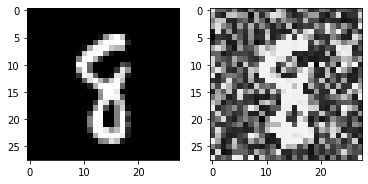

25  :  -0.18211311874534453 25
50  :  0.47565539661655987 25
75  :  0.330680041630991 25
100  :  0.4243147346551631 25
125  :  0.46978355000337896 25
150  :  0.46427047641894664 25
175  :  0.4711029105186389 25
200  :  0.48027442335703063 25
225  :  0.481480905163893 25
250  :  0.481068470298712 25
275  :  0.4819412167020952 25
300  :  0.48260979292958817 25
325  :  0.4836883431327008 25
350  :  0.48477298482548065 25
375  :  0.48539269561719817 25
400  :  0.48602845225772684 25
425  :  0.48607429958393167 25
450  :  0.4862935877716549 25
475  :  0.4874420363921466 25
500  :  0.48754297033464716 25
525  :  0.4877588324604186 25
550  :  0.48843317024855565 25
575  :  0.48846648466119735 25
600  :  0.48864452266830016 25
625  :  0.488808857644208 25
650  :  0.4890537478375843 25
675  :  0.4894039779546822 25
700  :  0.48973704668409307 25
725  :  0.48974052291916137 25
750  :  0.4899565249106813 25
775  :  0.4898214448433668 25
800  :  0.4900557733177832 25
825  :  0.4901033545979397 25


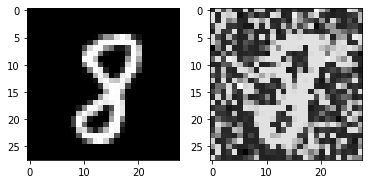

25  :  0.2372979986976266 25
50  :  0.4778955287783904 25
75  :  0.40847792866025956 25
100  :  0.4589717226303573 25
125  :  0.44478993564187175 25
150  :  0.46210028533242037 25
175  :  0.47397680172253276 25
200  :  0.47769089097992806 25
225  :  0.4787993059105066 25
250  :  0.48080437237112855 25
275  :  0.48160386367409186 25
300  :  0.4820295711677193 25
325  :  0.4835188094705577 25
350  :  0.48251221019833807 25
375  :  0.48360107451382084 25
400  :  0.4838175836767956 25
425  :  0.4847170786860144 25
450  :  0.48426674794258223 25
475  :  0.48559302643983765 25
500  :  0.48481673369422945 25
525  :  0.48577432064412174 25
550  :  0.4861292472738284 25
575  :  0.4863896201990277 25
600  :  0.4865344101163039 25
625  :  0.4871409265750682 25
650  :  0.4869534957096096 25
675  :  0.4873254290659264 25
700  :  0.4875512312263668 25
725  :  0.4877101930920525 25
750  :  0.4877969367458587 25
775  :  0.48822526818200324 25
800  :  0.4882310177093905 25
825  :  0.4886061232387953 25

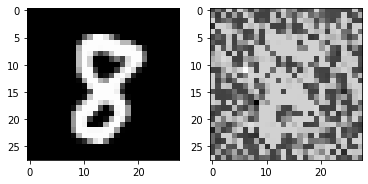

25  :  0.4695779765660851 25
50  :  0.48909240631541473 25
75  :  0.4745093189361758 25
100  :  0.4881839113485693 25
125  :  0.4894208953083944 25
150  :  0.49044041202368266 25
175  :  0.48821282594782933 25
200  :  0.4875491668480686 25
225  :  0.48699707326697383 25
250  :  0.48719934231958123 25
275  :  0.4892459569071213 25
300  :  0.48835488161132085 25
325  :  0.48978524049121214 25
350  :  0.4894805275508852 25
375  :  0.4901578617485693 25
400  :  0.49067428518976075 25
425  :  0.4906495135384968 25
450  :  0.49060758888044326 25
475  :  0.4905912992332802 25
500  :  0.49100913272076513 25
525  :  0.49094832084189316 25
550  :  0.4909754066418767 25
575  :  0.49117419008991325 25
600  :  0.49118080619075316 25
625  :  0.4913050784446416 25
650  :  0.4913651471030994 25
675  :  0.49136457548596796 25
700  :  0.4914000755839721 25
725  :  0.4914162824289115 25
750  :  0.49141134760245775 25
775  :  0.49151155833826815 25
800  :  0.49155605453003764 25
825  :  0.4916289420473866

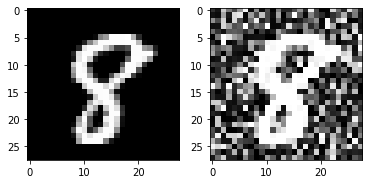

25  :  0.3653723402846932 25
50  :  0.48426295407067865 25
75  :  0.48341651086480913 25
100  :  0.48724211794975586 25
125  :  0.4872189963454551 25
150  :  0.4878493168465648 25
175  :  0.4885437745956668 25
200  :  0.4877630240266268 25
225  :  0.48683660979426385 25
250  :  0.48757345258066415 25
275  :  0.48879388336391055 25
300  :  0.489574029002856 25
325  :  0.49008952740525785 25
350  :  0.48989163875246583 25
375  :  0.48979718508191855 25
400  :  0.48982298204755353 25
425  :  0.49036656705760906 25
450  :  0.4900179196929612 25
475  :  0.4903788246683365 25
500  :  0.490415332386025 25
525  :  0.4903481649959976 25
550  :  0.4905902005879826 25
575  :  0.49078135563284814 25
600  :  0.49091146827032806 25
625  :  0.49110562416763853 25
650  :  0.4910622330387763 25
675  :  0.49109110167703657 25
700  :  0.4912360077576689 25
725  :  0.49127810209405226 25
750  :  0.49130538682115726 25
775  :  0.49142188719171115 25
800  :  0.49145789174273186 25
825  :  0.4916014057873939

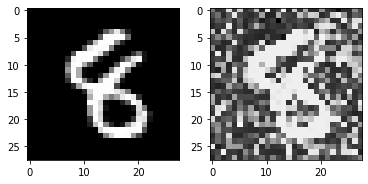

25  :  0.43751465758214003 25
50  :  0.48768940498668334 25
75  :  0.4717094803705896 25
100  :  0.45945312042200803 25
125  :  0.4861757500803115 25
150  :  0.48348137380698275 25
175  :  0.48478735987930965 25
200  :  0.4854708166251553 25
225  :  0.4864847107861241 25
250  :  0.48759744346085354 25
275  :  0.48716820045691506 25
300  :  0.48725060242746515 25
325  :  0.4876790476246298 25
350  :  0.48812182102478113 25
375  :  0.4884777704239403 25
400  :  0.4886829761276465 25
425  :  0.48918600784933236 25
450  :  0.4889660048206098 25
475  :  0.488967263945605 25
500  :  0.48902320106566655 25
525  :  0.48941895558199505 25
550  :  0.48949138956396887 25
575  :  0.48940481975735495 25
600  :  0.4895736899256805 25
625  :  0.48965120272231394 25
650  :  0.48974941040153464 25
675  :  0.4898427291523332 25
700  :  0.4898675708229256 25
725  :  0.4899243397885547 25
750  :  0.48996973564306306 25
775  :  0.4899798313742044 25
800  :  0.49009842526740977 25
825  :  0.49014285089398 2

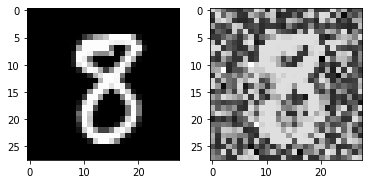

25  :  -0.05038827661764267 25
50  :  0.46886094342946705 25
75  :  0.444215402403471 25
100  :  0.4695181388678771 25
125  :  0.4699302458942067 25
150  :  0.47422529876537156 25
175  :  0.47837830153642014 25
200  :  0.4811641562647883 25
225  :  0.482702577513909 25
250  :  0.48104165073890204 25
275  :  0.4815215363385457 25
300  :  0.4829005133092411 25
325  :  0.4832835039209762 25
350  :  0.4846049151377925 25
375  :  0.48594481617287033 25
400  :  0.48655745617402685 25
425  :  0.4875620458102249 25
450  :  0.4880888699648038 25
475  :  0.4886084437104184 25
500  :  0.4896471476192133 25
525  :  0.4895008887135821 25
550  :  0.49021273581747543 25
575  :  0.48984860490466187 25
600  :  0.4904669883192177 25
625  :  0.4900328152283333 25
650  :  0.4901121721381349 25
675  :  0.49006901134985453 25
700  :  0.4904447492337034 25
725  :  0.4901905783908257 25
750  :  0.49030700503204 25
775  :  0.490339839099586 25
800  :  0.49045980832279407 25
825  :  0.49041244365370074 25
850  

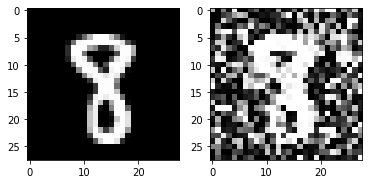

25  :  0.12013274325748367 25
50  :  0.35576047825777135 25
75  :  0.2404680017561421 25
100  :  0.3063850462772007 25
125  :  0.3014383469123577 25
150  :  0.4188443747627811 25
175  :  0.41231100281678457 25
200  :  0.4570958625157663 25
225  :  0.4757796232466988 25
250  :  0.481359248306653 25
275  :  0.47988503843297636 25
300  :  0.48121398136654503 25
325  :  0.4821973381427122 25
350  :  0.48305322431558445 25
375  :  0.48258383297132434 25
400  :  0.48314390752906516 25
425  :  0.4841216758655409 25
450  :  0.4841515240863478 25
475  :  0.4850606458302427 25
500  :  0.4858198622411873 25
525  :  0.4861602453500052 25
550  :  0.48632584452922656 25
575  :  0.4868862610810971 25
600  :  0.4871489829641476 25
625  :  0.4873916140157824 25
650  :  0.4873350638860484 25
675  :  0.48767620257857613 25
700  :  0.487791895965935 25
725  :  0.4881215991597125 25
750  :  0.4884296557064981 25
775  :  0.4885586933930211 25
800  :  0.48860943543823565 25
825  :  0.4887065141322319 25
850 

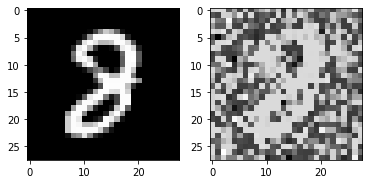

25  :  0.48676488168137955 25
50  :  0.4894133920087413 25
75  :  0.4876407678983071 25
100  :  0.4890288041798195 25
125  :  0.48886803254494515 25
150  :  0.48862981460324695 25
175  :  0.4878621662847271 25
200  :  0.48725270068815274 25
225  :  0.4862919194054483 25
250  :  0.48715616970020037 25
275  :  0.4885028637679793 25
300  :  0.4899136605344059 25
325  :  0.489551542919574 25
350  :  0.49040577994179646 25
375  :  0.49073439666785035 25
400  :  0.49073439666785035 25
425  :  0.49089046903179373 25
450  :  0.49105051930021754 25
475  :  0.49127557440674235 25
500  :  0.4915561414976797 25
525  :  0.4915781952149745 25
550  :  0.4918310065041093 25
575  :  0.49185451567031696 25
600  :  0.49211390291675494 25
625  :  0.49210778005120964 25
650  :  0.49213832961810383 25
675  :  0.49213832961810383 25
700  :  0.49213832961810383 25
725  :  0.4922569574398099 25
750  :  0.49227256451941376 25
775  :  0.49227256451941376 25
800  :  0.49231002006923696 25
Time:  98.6515166759491 

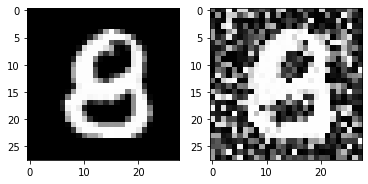

25  :  -0.23547617657739467 25
50  :  0.4531440902287718 25
75  :  0.45543907785467597 25
100  :  0.4330731722696301 25
125  :  0.47268878638917694 25
150  :  0.48115363362830155 25
175  :  0.4843229802122287 25
200  :  0.48483951849221235 25
225  :  0.4842007605523449 25
250  :  0.4844627958327507 25
275  :  0.48547142711682106 25
300  :  0.48713286054365373 25
325  :  0.48798699893984865 25
350  :  0.4876807905828873 25
375  :  0.4878918315397852 25
400  :  0.4882850329511562 25
425  :  0.4886878689459843 25
450  :  0.48894666042035173 25
475  :  0.4888721201279991 25
500  :  0.4889951423419952 25
525  :  0.48906732574958867 25
550  :  0.4891991790734384 25
575  :  0.4892707597638595 25
600  :  0.4893042777913547 25
625  :  0.48935750755046814 25
650  :  0.48951400397102673 25
675  :  0.489490427428035 25
700  :  0.489490427428035 25
725  :  0.489546192548493 25
750  :  0.48951534099817495 25
775  :  0.4895518787987738 25
800  :  0.4895896665035597 25
825  :  0.48958860648041663 25
8

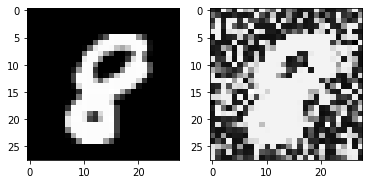

25  :  0.25987047121035206 25
50  :  0.472829502968281 25
75  :  0.4628705371786135 25
100  :  0.4699557480114464 25
125  :  0.48787559913220774 25
150  :  0.48632277312357897 25
175  :  0.4872871156661643 25
200  :  0.4879710087594117 25
225  :  0.4878889925282441 25
250  :  0.48626358075511744 25
275  :  0.48595818546468517 25
300  :  0.488352142967718 25
325  :  0.48816243381655466 25
350  :  0.4884585363056918 25
375  :  0.48946903801714137 25
400  :  0.489534965837869 25
425  :  0.49005112804165296 25
450  :  0.49005112804165296 25
475  :  0.49016984722763524 25
500  :  0.49029281472558606 25
525  :  0.49034405389553287 25
550  :  0.4905163902112369 25
575  :  0.4905752485265619 25
600  :  0.4906064364920343 25
625  :  0.4906662870672405 25
650  :  0.4906662870672405 25
675  :  0.4906662870672405 25
700  :  0.4906662870672405 25
725  :  0.4907066777718552 25
750  :  0.49075820095010164 25
775  :  0.4907977136520951 25
800  :  0.4909601472874206 25
825  :  0.4909608052827248 25
850

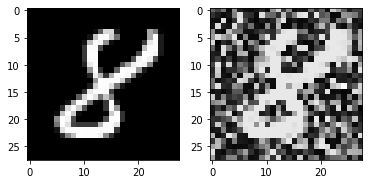

25  :  0.43525621629311906 25
50  :  0.4857068216282814 25
75  :  0.4729564563894638 25
100  :  0.48204156202106435 25
125  :  0.48695636211345 25
150  :  0.4863826398137114 25
175  :  0.48693633400556746 25
200  :  0.48806676757255046 25
225  :  0.4872877032416235 25
250  :  0.4868914006561027 25
275  :  0.48798110038825565 25
300  :  0.4879902061981603 25
325  :  0.4882023693808425 25
350  :  0.4891027662168593 25
375  :  0.48954933790985156 25
400  :  0.49007105260951545 25
425  :  0.490577046082577 25
450  :  0.49065707689044524 25
475  :  0.49095978397807605 25
500  :  0.49108515428785887 25
525  :  0.4913717626770459 25
550  :  0.4913805469299821 25
575  :  0.49146274412255647 25
600  :  0.4915052299841423 25
625  :  0.4916673131525447 25
650  :  0.4916921072518411 25
675  :  0.49165840644962705 25
700  :  0.4917430527032596 25
725  :  0.491771286963404 25
750  :  0.49188064183685326 25
775  :  0.4919533942812251 25
800  :  0.4920019044466825 25
825  :  0.4920105184848843 25
850 

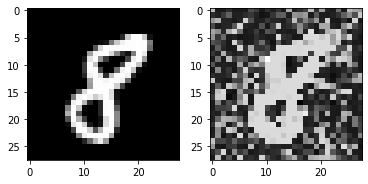

25  :  -0.2698690335304564 25
50  :  -0.23912225075235327 25
75  :  -0.22562000659968356 25
100  :  -0.13666518078422524 25
125  :  -0.07135668298075233 25
150  :  0.06153250871014536 25
175  :  0.2101179975660819 25
200  :  0.2974814706410228 25
225  :  0.3701505994882352 25
250  :  0.3520890133532154 25
275  :  0.34422970944479664 25
300  :  0.4229402525296109 25
325  :  0.486278769320103 25
350  :  0.4836328195703661 25
375  :  0.4889524835349793 25
400  :  0.4891009348015326 25
425  :  0.49010673127879945 25
450  :  0.4888137444156933 25
475  :  0.48884722403429054 25
500  :  0.48976807026449165 25
525  :  0.4901537918505794 25
550  :  0.49023405800344405 25
575  :  0.4902690468839605 25
600  :  0.49079040108286254 25
625  :  0.49081138763668564 25
650  :  0.4910515730523002 25
675  :  0.4910589851166302 25
700  :  0.4909750049055424 25
725  :  0.49140184234142026 25
750  :  0.4914575905914459 25
775  :  0.49148930442366023 25
800  :  0.49177496111521773 25
825  :  0.49177594185628

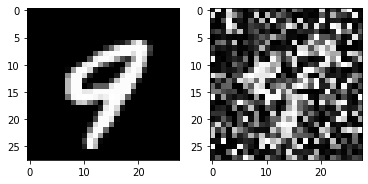

25  :  -0.48568656645328967 25
50  :  -0.48172977700839315 25
75  :  -0.4683352706518251 25
100  :  -0.47105699350558267 25
125  :  -0.3968659693858569 25
150  :  -0.2836194424767224 25
175  :  -0.3531870733180283 25
200  :  -0.1592800559168331 25
225  :  0.06331385006756766 25
250  :  0.39374752493409665 25
275  :  0.4598078035056308 25
300  :  0.48098572860662636 25
325  :  0.4819641384744856 25
350  :  0.48301867415733474 25
375  :  0.48220006671607796 25
400  :  0.48332717856625473 25
425  :  0.4832291986368837 25
450  :  0.4852686639192156 25
475  :  0.4855584783193858 25
500  :  0.48612866290694545 25
525  :  0.4865713779409887 25
550  :  0.486832212911698 25
575  :  0.48751114369212883 25
600  :  0.48791147508948285 25
625  :  0.4877859310889494 25
650  :  0.48824612315272325 25
675  :  0.4885111670392828 25
700  :  0.488459379623224 25
725  :  0.4885134928231075 25
750  :  0.48873337500916747 25
775  :  0.48874055302786484 25
800  :  0.4888117168767106 25
825  :  0.488853540500

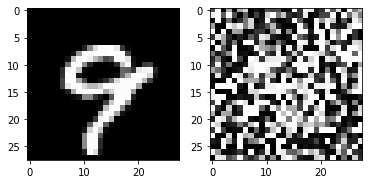

25  :  -0.10799843467746591 25
50  :  0.4538690842026472 25
75  :  0.47213115291272 25
100  :  0.46623980169982876 25
125  :  0.4785865944150877 25
150  :  0.4901176130497164 25
175  :  0.49005161465534974 25
200  :  0.4889397163691404 25
225  :  0.48872476258372466 25
250  :  0.48898016146987844 25
275  :  0.4893235985908305 25
300  :  0.49044794298716304 25
325  :  0.49034847963417605 25
350  :  0.49048271623573175 25
375  :  0.49062810778835053 25
400  :  0.49075318697738085 25
425  :  0.49107557165593657 25
450  :  0.49124850556005323 25
475  :  0.4923798581104828 25
500  :  0.4923798581104828 25
525  :  0.4923798581104828 25
550  :  0.4923798581104828 25
575  :  0.4923798581104828 25
600  :  0.4925410961556612 25
625  :  0.4925636976452525 25
650  :  0.49258625569263526 25
675  :  0.4926255008271314 25
700  :  0.4927067313574795 25
725  :  0.49271685795187686 25
750  :  0.49271685795187686 25
775  :  0.49272894603762035 25
800  :  0.4927571600806635 25
825  :  0.4928154235404109 2

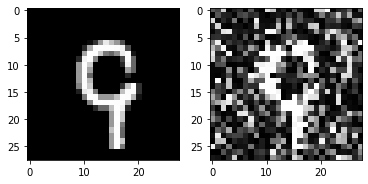

25  :  -0.21268074221589592 25
50  :  0.048270508522777665 25
75  :  -0.0664976793037653 25
100  :  0.016509706717491305 25
125  :  0.20695591807896266 25
150  :  0.2631702826569602 25
175  :  0.3088559570480954 25
200  :  0.37936247370477055 25
225  :  0.385411064642355 25
250  :  0.41332474597613955 25
275  :  0.4448713494004873 25
300  :  0.4550983817060546 25
325  :  0.46124957771531794 25
350  :  0.4664889937252847 25
375  :  0.46864592244166153 25
400  :  0.4704067450046847 25
425  :  0.4720504505175619 25
450  :  0.4730441403799829 25
475  :  0.4753133882903666 25
500  :  0.47889853469005855 25
525  :  0.48166307991491186 25
550  :  0.4854557852141425 25
575  :  0.48640416018690696 25
600  :  0.4863680884331849 25
625  :  0.4863353390578243 25
650  :  0.48690734665592955 25
675  :  0.4872192007841065 25
700  :  0.4881289398978737 25
725  :  0.48845413320476516 25
750  :  0.4888095069900576 25
775  :  0.4893937943682407 25
800  :  0.4894410180504486 25
825  :  0.4900924627154692 

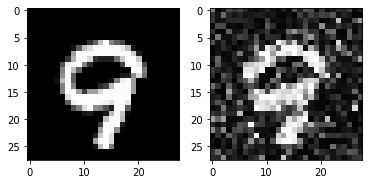

25  :  -0.4202559706507306 25
50  :  -0.29108636764071905 25
75  :  -0.3839368237681957 25
100  :  -0.3940447500295675 25
125  :  -0.25099394622087184 25
150  :  -0.16887924991655867 25
175  :  -0.09015482640823316 25
200  :  0.046213334539178814 25
225  :  0.17740126317335134 25
250  :  0.21640480800210377 25
275  :  0.45312685218484805 25
300  :  0.4750926989036233 25
325  :  0.4873824407099599 25
350  :  0.48760122955310387 25
375  :  0.4878084554150984 25
400  :  0.4871495606284908 25
425  :  0.4871174238460594 25
450  :  0.48728045979867407 25
475  :  0.4874986217067635 25
500  :  0.4885869190343685 25
525  :  0.489793922335273 25
550  :  0.49014356137258 25
575  :  0.49036190459388784 25
600  :  0.49042150016870134 25
625  :  0.4904577940503799 25
650  :  0.4903038496908107 25
675  :  0.49043963821237185 25
700  :  0.4905391082203326 25
725  :  0.490524574634758 25
750  :  0.49058177178511575 25
775  :  0.490895899976482 25
800  :  0.4909864131303557 25
825  :  0.4910152371390278

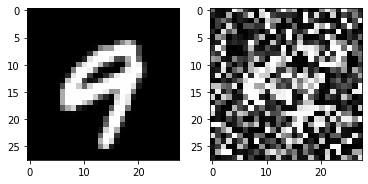

25  :  -0.45080857165063654 25
50  :  -0.4213562165602752 25
75  :  -0.3631511169935513 25
100  :  -0.3574183085877445 25
125  :  -0.19475242596129946 25
150  :  0.03463911920773203 25
175  :  0.08372450983948768 25
200  :  0.3163690164648766 25
225  :  0.43683439269477675 25
250  :  0.4576543291573156 25
275  :  0.4666678810982982 25
300  :  0.4671512916937808 25
325  :  0.4749186570158202 25
350  :  0.47752018880236324 25
375  :  0.47936267342157374 25
400  :  0.4824771857643416 25
425  :  0.4830947862203569 25
450  :  0.48364415705782066 25
475  :  0.4858916171746704 25
500  :  0.4868880745983695 25
525  :  0.48692786295734236 25
550  :  0.4886403431352847 25
575  :  0.490386754450336 25
600  :  0.49089576951943337 25
625  :  0.49090956374180034 25
650  :  0.49119732466824706 25
675  :  0.4913255677124567 25
700  :  0.49140948951055147 25
725  :  0.4916038755474653 25
750  :  0.49176455551917203 25
775  :  0.49184226630719025 25
800  :  0.4919229232064697 25
825  :  0.49192443397769

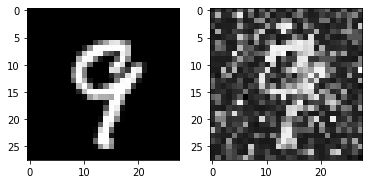

25  :  -0.3678783865425507 25
50  :  -0.335640587924604 25
75  :  -0.31672262493663755 25
100  :  -0.25628347115848576 25
125  :  -0.16934477167250728 25
150  :  0.06714391771022875 25
175  :  0.3440689382158768 25
200  :  0.37456598369852484 25
225  :  0.39807405157325965 25
250  :  0.4053105882243236 25
275  :  0.4414332797915442 25
300  :  0.4449923363899723 25
325  :  0.4553331586131795 25
350  :  0.4565749066047719 25
375  :  0.4565749066047719 25
400  :  0.4679795866673528 25
425  :  0.47208583112993757 25
450  :  0.4745241934295565 25
475  :  0.4775448348740475 25
500  :  0.47959096685078906 25
525  :  0.4822618310770916 25
550  :  0.4830387359782383 25
575  :  0.4850032621661108 25
600  :  0.4855633742610661 25
625  :  0.4867556772671628 25
650  :  0.48787579828424127 25
675  :  0.48965573007246604 25
700  :  0.49053699717984234 25
725  :  0.4905545007265947 25
750  :  0.4905545007265947 25
775  :  0.49124097077510404 25
800  :  0.49121223156555915 25
825  :  0.4912237954196799

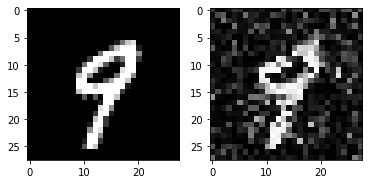

25  :  0.3191031982875289 25
50  :  0.45490775644629894 25
75  :  0.44907997313356773 25
100  :  0.4790530182996631 25
125  :  0.48412905987568955 25
150  :  0.488341503271985 25
175  :  0.49034194462855324 25
200  :  0.4902569898868829 25
225  :  0.488537046310155 25
250  :  0.4904423149210271 25
275  :  0.48982695373837243 25
300  :  0.4899516024524681 25
325  :  0.49014062328995195 25
350  :  0.4911545443890045 25
375  :  0.4910214265515421 25
400  :  0.4922252908638436 25
425  :  0.49273977687698184 25
450  :  0.4929012774685971 25
475  :  0.4928688576783782 25
500  :  0.4928688576783782 25
525  :  0.493267113737118 25
550  :  0.4931599638655966 25
575  :  0.4931599638655966 25
600  :  0.4931599638655966 25
625  :  0.49330517311479316 25
650  :  0.4932916861533378 25
675  :  0.49331222250129686 25
700  :  0.4934584187696903 25
725  :  0.4934830541319008 25
750  :  0.4934953658996508 25
775  :  0.4934839093193459 25
800  :  0.49353290968934277 25
825  :  0.49358827286849777 25
850  

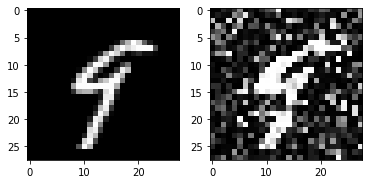

25  :  -0.40434877046675377 25
50  :  0.43483024272689763 25
75  :  -0.33296119506089666 25
100  :  -0.23592527360939974 25
125  :  -0.36186899003282047 25
150  :  -0.06030507662581479 25
175  :  0.14682619093492813 25
200  :  -0.08164144986705459 25
225  :  0.27530128865149683 25
250  :  0.4308704446203757 25
275  :  0.48462248512737016 25
300  :  0.4846846414392396 25
325  :  0.4850350130208306 25
350  :  0.4858658844402658 25
375  :  0.4853439711505776 25
400  :  0.4856238219580825 25
425  :  0.4874609290078306 25
450  :  0.4882978069367241 25
475  :  0.48871441006268035 25
500  :  0.4889230927327755 25
525  :  0.4889224135098337 25
550  :  0.48968417625310107 25
575  :  0.4900708136740094 25
600  :  0.4900708136740094 25
625  :  0.490532641778136 25
650  :  0.4905356999231393 25
675  :  0.4905851983882863 25
700  :  0.49060226297076426 25
725  :  0.49068375743395665 25
750  :  0.49068375743395665 25
775  :  0.49068375743395665 25
800  :  0.49076588812935035 25
825  :  0.49085426727

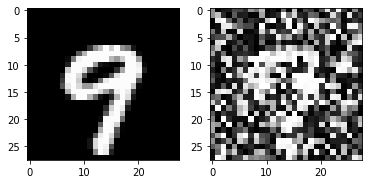

25  :  -0.31892008530308963 25
50  :  -0.14149877053856674 25
75  :  0.23409564619450463 25
100  :  0.09953481461058777 25
125  :  0.1666198586484824 25
150  :  0.37597287064413115 25
175  :  0.4536331451132286 25
200  :  0.467806015265696 25
225  :  0.47592359089433445 25
250  :  0.47592359089433445 25
275  :  0.48032555169690494 25
300  :  0.4874912647997057 25
325  :  0.48785989733089374 25
350  :  0.49064521563126595 25
375  :  0.49068843667639744 25
400  :  0.49156163875181286 25
425  :  0.4931412029156296 25
450  :  0.4937688003251687 25
475  :  0.49361594565619715 25
500  :  0.49361594565619715 25
525  :  0.4936172312151178 25
550  :  0.4937243927226848 25
575  :  0.49377292805462986 25
600  :  0.49384267149641764 25
625  :  0.4940689622283358 25
650  :  0.49407725745958075 25
675  :  0.49416391045554514 25
700  :  0.494207867688107 25
725  :  0.4943458018020896 25
750  :  0.49434343278041876 25
775  :  0.49456264975300596 25
800  :  0.49456264975300596 25
825  :  0.494595727443

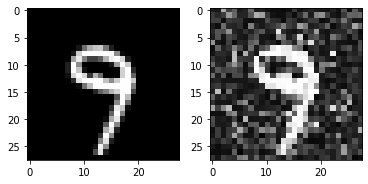

25  :  0.4860482203265158 25
50  :  0.49131430811172166 25
75  :  0.48636628457995823 25
100  :  0.48921649348507484 25
125  :  0.49223402704083785 25
150  :  0.49041428044991164 25
175  :  0.4912363630433708 25
200  :  0.49285678186117077 25
225  :  0.4919721780985482 25
250  :  0.4913828924977569 25
275  :  0.4923094094567726 25
300  :  0.49227707198673165 25
325  :  0.49253075379139233 25
350  :  0.49268989766022026 25
375  :  0.4925991567889864 25
400  :  0.49265862940557975 25
425  :  0.4926983088932967 25
450  :  0.4928578238619036 25
475  :  0.4931109354718207 25
500  :  0.4931449226775046 25
525  :  0.49328397678940306 25
550  :  0.49338557050110826 25
575  :  0.4934956299660888 25
600  :  0.49359120802685125 25
625  :  0.49362279730838204 25
650  :  0.4936174472270225 25
675  :  0.49367490449235196 25
700  :  0.4937448758547429 25
725  :  0.493778626585422 25
750  :  0.4937993934032928 25
775  :  0.4938753333216035 25
800  :  0.49387594458003314 25
Time:  90.67219829559326  se

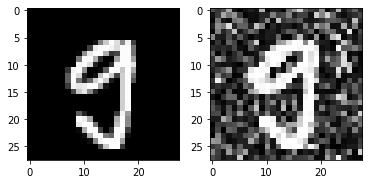

25  :  -0.29741327523957095 25
50  :  0.3293211663477748 25
75  :  0.020388176182746912 25
100  :  -0.05652109849289831 25
125  :  0.35158551613879313 25
150  :  0.4607689720590669 25
175  :  0.4767520244743591 25
200  :  0.4852082196572761 25
225  :  0.48645727863869526 25
250  :  0.4874071052980619 25
275  :  0.48703860881670885 25
300  :  0.48704935013703315 25
325  :  0.4883444152921817 25
350  :  0.4894955824536165 25
375  :  0.48958530873613015 25
400  :  0.4900126156385701 25
425  :  0.4899782554926069 25
450  :  0.4899782554926069 25
475  :  0.4899782554926069 25
500  :  0.4901447768929753 25
525  :  0.49012984537280985 25
550  :  0.49045208156373243 25
575  :  0.4904238870339026 25
600  :  0.4905139634053192 25
625  :  0.4908134408116755 25
650  :  0.4907454914748256 25
675  :  0.4907454914748256 25
700  :  0.4908612007051132 25
725  :  0.4909015787564966 25
750  :  0.49092245784810384 25
775  :  0.4910686235503874 25
800  :  0.4911392695886665 25
825  :  0.4911480121935101 25

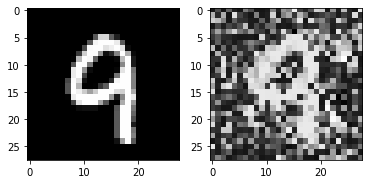

25  :  -0.3594346320708939 25
50  :  0.3383703567488924 25
75  :  0.11432600284906844 25
100  :  0.2088151916648804 25
125  :  0.3210262129878278 25
150  :  0.3820745481046744 25
175  :  0.4465893209644281 25
200  :  0.47643208761933337 25
225  :  0.4807649655848512 25
250  :  0.4842105236359581 25
275  :  0.4843893263536525 25
300  :  0.4850845631494352 25
325  :  0.4853735976575984 25
350  :  0.4855278854850998 25
375  :  0.4854887332613648 25
400  :  0.48576067055314304 25
425  :  0.4866401007275339 25
450  :  0.48687314687432515 25
475  :  0.488230504234611 25
500  :  0.48814605431160946 25
525  :  0.48836957805843895 25
550  :  0.4885614633957133 25
575  :  0.4886331759676893 25
600  :  0.48896188959661524 25
625  :  0.4892220839171532 25
650  :  0.48925188833329253 25
675  :  0.4894600309507793 25
700  :  0.48953205206399253 25
725  :  0.4897708365839023 25
750  :  0.48976439171291913 25
775  :  0.4898004917741276 25
800  :  0.4898808099431137 25
825  :  0.4899369228991504 25
850

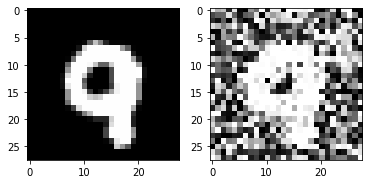

In [9]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28*28) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_rbf_mnist_seed1', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [11]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

189.69730067253113
74.16106057167053
116.38379262174878
27.821372910607636


In [12]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

1724
800
1000.3333333333334
160.49417731612868


In [13]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

16.813900998710164
3.7655478962545224
8.687654186308729
3.0709005868829795
